In [13]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as f
from sklearn.model_selection import train_test_split

In [14]:
class MLP(nn.Module):
    def __init__(self, architecture, activation, dropout_p=0.0):
        super(MLP, self).__init__() # chama o construtor da classe pai.
        self.layers = nn.ModuleList()
        self.activation_name = activation
        self.dropout_p = dropout_p

        for i in range(len(architecture) - 1):
            self.layers.append(nn.Linear(architecture[i], architecture[i+1]))

    def forward(self, x):
        for i, layer in enumerate(self.layers[:-1]):
            x = layer(x)
            if self.activation_name == 'relu':
                x = f.relu(x)
            elif self.activation_name == 'tanh':
                x = torch.tanh(x)
            if self.dropout_p > 0:
                x = f.dropout(x, p=self.dropout_p, training=self.training)
        x = self.layers[-1](x)  # última camada (sem ativação)
        return x


# retorna um número entre 0 e 1 representando o quão bom foi. 0 = pior resultado (muito longe), 1 = acertou
def binary_accuracy(preds, labels, threshold=0.5):
    probs = torch.sigmoid(preds)
    preds_class = (probs > threshold).float()
    return (preds_class == labels).float().mean().item()

# Retorna a proporção de exemplos que a rede previu corretamente.
def multiclass_accuracy(preds, labels):
    preds_class = preds.argmax(dim=1)                # escolhe classe com maior logit
    return (preds_class == labels).float().mean().item()




In [51]:
def train_model_with_validation(model, optimizer, criterion, x_train, y_train, x_val, y_val, epochs, patience, show_logs=False):
    best_loss = float('inf')
    best_acc = float(0)
    best_model = None
    patience_counter = 0

    history = {'train_loss': [], 'val_loss': [], 'train_acc': [], 'val_acc': []}

    # Detecta qual método vai usar para avaliacao
    unique_labels = torch.unique(y_train)
    is_binary = len(unique_labels) == 2 and set(unique_labels.tolist()) <= {0, 1}
    acc_fn = binary_accuracy if is_binary else multiclass_accuracy
    if show_logs:
        tipo = "binário" if is_binary else "multiclasse"
        print(f"🚀 Detecção automática: problema {tipo}. Usando {'binary_accuracy' if is_binary else 'multiclass_accuracy'}.")

    
    for epoch in range(epochs):

        # Treinamento
        model.train() # Coloca a rede em modo treinamento. (ativa dropout, etc)
        outputs = model(x_train) # faz o forward pass — aplica as camadas da rede nos dados de treino.
        loss = criterion(outputs, y_train) # calcula a função de perda com as saídas da rede e os rótulos reais.
        optimizer.zero_grad() # zera os gradientes antigos acumulados (importante!).
        loss.backward() # calcula os gradientes da perda em relação aos pesos (backpropagation).
        optimizer.step() # atualiza os pesos da rede com base nos gradientes.

        # Avaliação
        model.eval() # coloca a rede em modo avaliação (desativa dropout, etc).
        with torch.no_grad(): # desativa o rastreamento de gradientes — melhora a performance e reduz uso de memória.
            train_acc = acc_fn(outputs, y_train) # Mede a acurácia no conjunto de treinamento
            
            val_outputs = model(x_val) # Obtém os outputs do conjunto de validação.
            val_loss = criterion(val_outputs, y_val) # Calcula novamente a perda, agora com os dados de validação.
            val_acc = acc_fn(val_outputs, y_val) # Mede a acurácia no conjunto de validação.

        # Armazena as métricas obtidas pelo treinamento/validação no dicionário history.
        history['train_loss'].append(loss.item())
        history['train_acc'].append(train_acc)

        history['val_loss'].append(val_loss.item())
        history['val_acc'].append(val_acc)
        
        if show_logs:
            print(f"Epoch {epoch+1}, Train Loss: {loss.item():.4f}, Val Loss: {val_loss.item():.4f}, Train Acc {train_acc:.4f}, Val Acc {val_acc:.4f}")

        # Early stopping - with validation set
        if val_loss < best_loss:
            best_loss = val_loss
            best_model = model.state_dict()
            best_acc = val_acc
            patience_counter = 0
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print("Early stopping triggered.")
                break

    # Restaura o melhor modelo salvo.
    if best_model is not None:
        model.load_state_dict(best_model)
        print(f" Conjunto de validação --> Loss: {best_loss:.4f}, Acurácia: {best_acc:.4f}")
    return model, history

def evaluate_model(model, x, y, criterion):
    model.eval()
    with torch.no_grad():
        outputs = model(x)
        loss = criterion(outputs, y)

        # Verifica se a validação deve ser feita pelo método binário ou multiclasse.
        unique_labels = torch.unique(y)
        is_binary = len(unique_labels) == 2 and set(unique_labels.tolist()) <= {0, 1}
        acc_fn = binary_accuracy if is_binary else multiclass_accuracy
        acc = acc_fn(outputs, y)

    return loss.item(), acc


In [65]:
def plota_treinamento(history, epochs, nome_experimento = ''):
    epochs = range(1, len(history['train_loss']) + 1)

    # Figura com 2 subplots (loss e accuracy)
    plt.figure(figsize=(14, 5))

    # Loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs, history['train_loss'], label='Train Loss')
    if 'val_loss' in history and history['val_loss']:
        plt.plot(epochs, history['val_loss'], label='Val Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Loss over Epochs')
    plt.legend()
    plt.grid(True)

    # Accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, history['train_acc'], label='Train Acc')
    if 'val_acc' in history and history['val_acc']:
        plt.plot(epochs, history['val_acc'], label='Val Acc')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title(f'Curva de Acurácia {f"- {nome_experimento}" if nome_experimento else ""}')

    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()


def plota_regiao_decisao(model, X, Y, resolution=0.01, title='Região de Decisão'):
    """
    Plota a região de decisão do modelo treinado (MLP não-linear).
    
    Parâmetros:
    - model: rede treinada (PyTorch)
    - X: dados de entrada (numpy array)
    - Y: rótulos (0 ou 1)
    - resolution: resolução da malha para o grid (quanto menor, mais detalhado)
    """
    from matplotlib.colors import ListedColormap

    # Garante que o modelo está em modo avaliação
    model.eval()

    # Define os limites do grid
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1

    # Gera grid de pontos
    xx, yy = np.meshgrid(np.arange(x_min, x_max, resolution),
                         np.arange(y_min, y_max, resolution))
    
    # Prepara a entrada do modelo (tensores 2D -> 2 colunas)
    grid = np.c_[xx.ravel(), yy.ravel()]
    grid_tensor = torch.from_numpy(grid).float()

    # Faz predição com a rede
    with torch.no_grad():
        outputs = model(grid_tensor)
        probs = torch.sigmoid(outputs).numpy()
        Z = (probs > 0.5).astype(int).reshape(xx.shape)

    # Plot
    plt.figure(figsize=(8, 6))
    cmap_light = ListedColormap(['#FFAAAA', '#AAAAFF'])

    plt.contourf(xx, yy, Z, cmap=cmap_light, alpha=0.5)

    # Pontos reais
    X_pos = X[Y == 1]
    X_neg = X[Y == 0]
    plt.scatter(X_pos[:, 0], X_pos[:, 1], c='blue', label='Classe 1', edgecolor='k')
    plt.scatter(X_neg[:, 0], X_neg[:, 1], c='red', label='Classe 0', edgecolor='k')

    plt.title(title)
    plt.xlabel('Atributo 1')
    plt.ylabel('Atributo 2')
    plt.legend()
    plt.grid(True)
    plt.show()


In [66]:
def get_train_data(path_treinamento, path_testes):

    df_train_loaded = pd.read_csv(path_treinamento)
    df_test_loaded = pd.read_csv(path_testes)
    
    x_train = df_train_loaded.drop('label', axis=1).values
    y_train = df_train_loaded['label'].values
    
    x_test = df_test_loaded.drop('label', axis=1).values
    y_test = df_test_loaded['label'].values
    
    
    # Divide o conjunto de treino em 90% treino e 10% validação
    x_test_split, x_val_split, y_test_split, y_val_split = train_test_split(
        x_test,
        y_test,
        test_size=0.5, # 15% do conjunto de treino vai ser agora o conjunto de validação.
        random_state=42,
        stratify=y_test) # Mantém a proporção das classes na reprodução (gera sub-conjuntos bem representativos)
    
    # AJustes necessários nos ddos para usar um classificador binário. Motivo: Os resultados estão como -1 e 1, mas queremos usar 0 e 1 !!!
    y_train = (y_train == 1).astype(float)
    y_val_split = (y_val_split == 1).astype(float)
    y_test_split = (y_test_split == 1).astype(float)
    
    
    # Trasformando os numpy arrays em tensores (requisito do torch).
    x_train_tensor = torch.from_numpy(x_train).float()
    y_train_tensor = torch.from_numpy(y_train).float().view(-1, 1) # o view transforma em uma matriz com n vetores de  tamanho 1 (exigência do pytorch)
    
    x_val_tensor = torch.from_numpy(x_val_split).float()
    y_val_tensor = torch.from_numpy(y_val_split).float().view(-1, 1)
    
    x_test_tensor = torch.from_numpy(x_test_split).float()
    y_test_tensor = torch.from_numpy(y_test_split).float().view(-1, 1) # o view transforma em uma matriz com n vetores de  tamanho 1 (exigência do pytorch)

    return x_train_tensor, y_train_tensor, x_val_tensor, y_val_tensor, x_test_tensor, y_test_tensor

## Experimento 1

Camadas = 2, 3, 1

fx_ativacao =  tanh

lr = 0.1

Otimizador: Stochastic gradient descendent

Função de perda (ou de custo): Mede o quão ruim está a previsão da rede em relação à resposta esperada. Calcula o erro da rede. É calculado no forward e usado no backpropagation para ajustar os pesos. Utilizando: Binary cross entropy (medida antes da função de ativação da saída)



Patience: A partir de quantas iterações sem melhoria do erro eu devo parar

 Conjunto de validação --> Loss: 0.2119, Acurácia: 0.9333


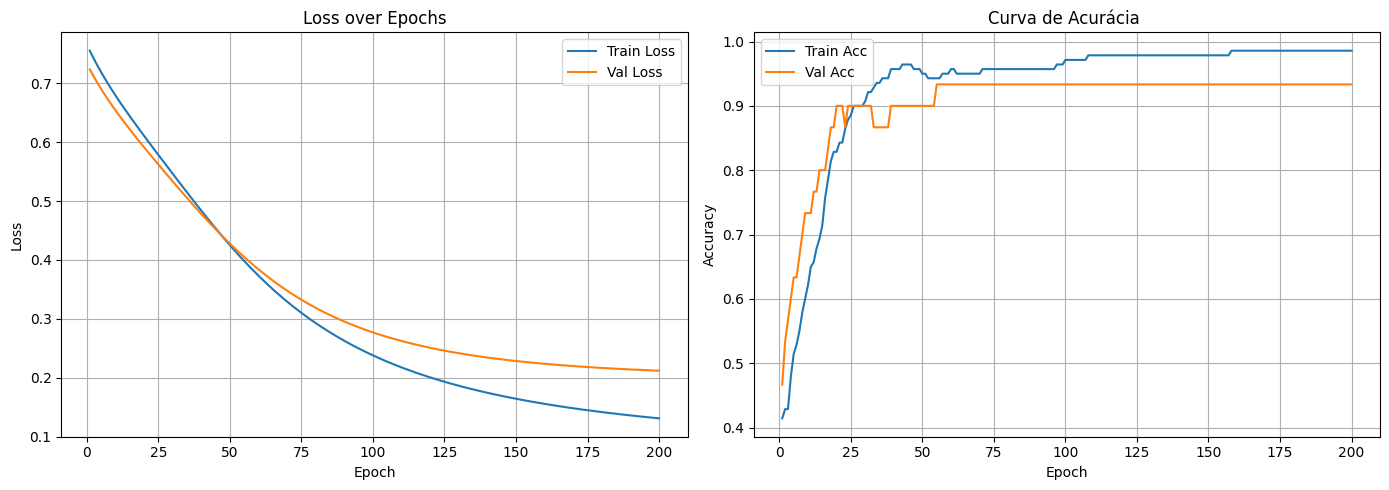

--- Resultados --- 
 Conjunto de testes ---> Loss: 0.1448, Acurácia: 0.9667


In [67]:
camadas1 = [2, 3, 1]
fx_ativacao1 = 'tanh'
probabilidade_dropout1 = 0.0 # sem dropout

modelo1 = MLP(camadas1, fx_ativacao1, probabilidade_dropout1)

optimizer1 = torch.optim.SGD(modelo1.parameters(), lr=0.1)
criterion1 = nn.BCEWithLogitsLoss()
epochs1 = 200
patience1 = 10
#criterion = nn.CrossEntropyLoss()  # ou BCEWithLogitsLoss para binário
x_train_tensor1, y_train_tensor1, x_val_tensor1, y_val_tensor1, x_test_tensor1, y_test_tensor1 = get_train_data(
        path_treinamento = "..\\perceptron_datasets\\train_dataset1.csv",
        path_testes = "..\\perceptron_datasets\\test_dataset1.csv")

# Sem validação
model_trained1, history1 = train_model_with_validation(modelo1, 
                                                     optimizer1, 
                                                     criterion1, 
                                                     x_train_tensor1, 
                                                     y_train_tensor1,
                                                     x_val_tensor1,
                                                     y_val_tensor1, 
                                                     epochs1, 
                                                     patience1)

plota_treinamento(history1, epochs1)

loss1, acc1 = evaluate_model(model_trained1, x_test_tensor1, y_test_tensor1, criterion1)

print(f"--- Resultados --- ")
print(f" Conjunto de testes ---> Loss: {loss1:.4f}, Acurácia: {acc1:.4f}")



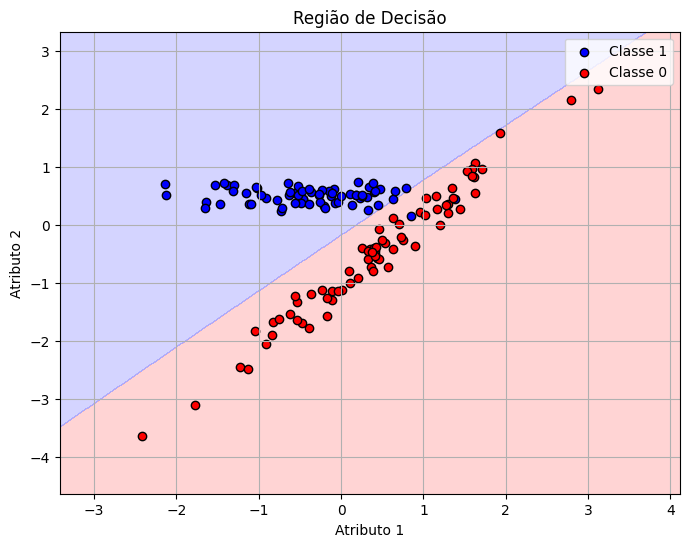

In [68]:
plota_regiao_decisao(model_trained1, x_train_tensor1.numpy(), y_train_tensor1.numpy().flatten())

### Salvar e carregar o modelo
Caso queira salvar o modelo para carregar posteriormente, utilize:

In [69]:
# Para salvar:
torch.save(model_trained1.state_dict(), 'modelo_treinado_ex1_tanh_231.pth')

# Para carregar:
# Recrie a arquitetura igual à do treinamento
model1 = MLP([2, 3, 1], activation='tanh')
model1.load_state_dict(torch.load('modelo_treinado_ex1_tanh_231.pth'))
model1.eval()  # coloca em modo de avaliação (sem dropout, etc)


MLP(
  (layers): ModuleList(
    (0): Linear(in_features=2, out_features=3, bias=True)
    (1): Linear(in_features=3, out_features=1, bias=True)
  )
)

## Experimento 2

Camada: 261



fx_ativacao = ta
Dropout: false
nh

lr = O.1

Otimizador: Stochastic gradient descendent

Função de perda (ou delizando: Binary cros devo parar

 Conjunto de validação --> Loss: 0.0269, Acurácia: 1.0000


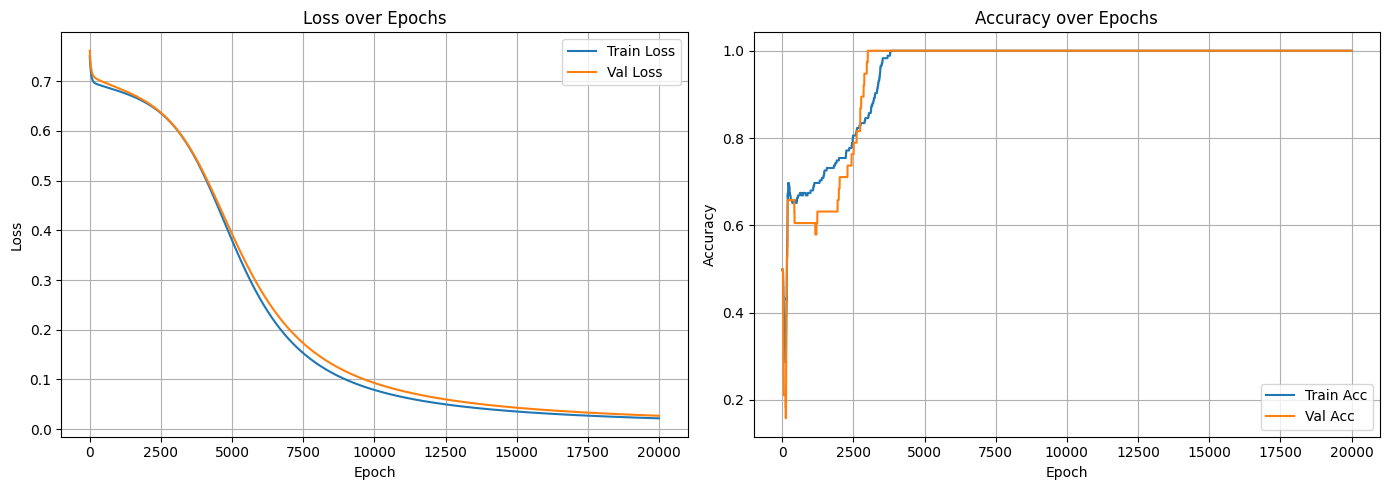

--- Resultados --- 
 Conjunto de testes ---> Loss: 0.0254, Acurácia: 1.0000


In [30]:
camadas2 = [2, 20, 1]
fx_ativacao2 = 'tanh'
probabilidade_dropout2 = 0.0 # sem dropout

modelo2 = MLP(camadas2, fx_ativacao2, probabilidade_dropout2)

optimizer2 = torch.optim.SGD(modelo2.parameters(), lr=0.01)
criterion2 = nn.BCEWithLogitsLoss()
epochs2 = 20000
patience2 = 10
#criterion = nn.CrossEntropyLoss()  # ou BCEWithLogitsLoss para binário
x_train_tensor2, y_train_tensor2, x_val_tensor2, y_val_tensor2, x_test_tensor2, y_test_tensor2 = get_train_data(
        path_treinamento = "..\\perceptron_datasets\\train_dataset2.csv",
        path_testes = "..\\perceptron_datasets\\test_dataset2.csv")

# Sem validação
model_trained2, history2 = train_model_with_validation(modelo2, 
                                                     optimizer2, 
                                                     criterion2, 
                                                     x_train_tensor2, 
                                                     y_train_tensor2,
                                                     x_val_tensor2,
                                                     y_val_tensor2, 
                                                     epochs2, 
                                                     patience2)

plota_treinamento(history2, epochs2)

loss, acc = evaluate_model(model_trained2, x_test_tensor2, y_test_tensor2, criterion2)

print(f"--- Resultados --- ")
print(f" Conjunto de testes ---> Loss: {loss:.4f}, Acurácia: {acc:.4f}")


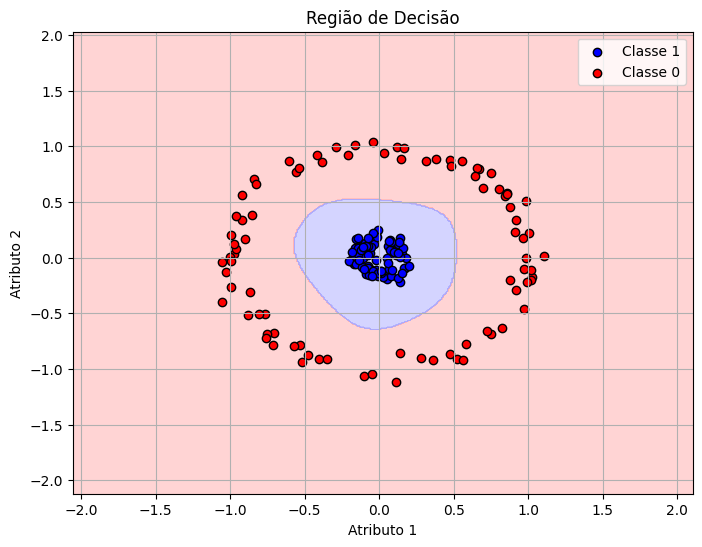

In [31]:
plota_regiao_decisao(model_trained2, x_train_tensor2.numpy(), y_train_tensor2.numpy().flatten())

## Experimentos com dataset 4


In [58]:
import itertools
import random


def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

In [70]:
# Extrair features e r ́otulos (no formato transposto)

path_treinamento = "..\\perceptron_datasets\\train_dataset4.csv"
path_validacao = "..\\perceptron_datasets\\val_dataset4.csv"
path_testes = "..\\perceptron_datasets\\test_dataset4.csv"


df_train_loaded = pd.read_csv(path_treinamento)
df_val_loaded = pd.read_csv(path_validacao)
df_test_loaded = pd.read_csv(path_testes)

X_train_loaded = df_train_loaded.drop('label', axis=1).values.T # (50, 768)
y_train_loaded = df_train_loaded['label'].values.reshape(1, -1) # (1, 768)
X_val_loaded = df_val_loaded.drop('label', axis=1).values.T # (50, 192)
y_val_loaded = df_val_loaded['label'].values.reshape(1, -1) # (1, 192)
X_test_loaded = df_test_loaded.drop('label', axis=1).values.T # (50, 240)
y_test_loaded = df_test_loaded['label'].values.reshape(1, -1) # (1, 240)

print(f"Formato dos dados carregados:")
print(f"X_train_loaded: {X_train_loaded.shape}") # Deve mostrar (50, 768)
print(f"y_train_loaded: {y_train_loaded.shape}") # Deve mostrar (1, 768)
print(f"X_val_loaded: {X_val_loaded.shape}") # Deve mostrar (50, 192)
print(f"y_val_loaded: {y_val_loaded.shape}") # Deve mostrar (1, 192)
print(f"X_test_loaded: {X_test_loaded.shape}") # Deve mostrar (50, 240)
print(f"y_test_loaded: {y_test_loaded.shape}") # Deve mostrar (1, 240)



# Dados convertidos para tensores
x_train_tensor_4 = torch.from_numpy(X_train_loaded.T).float()
y_train_tensor_4 = torch.from_numpy(y_train_loaded.T).long().squeeze()
x_val_tensor_4 = torch.from_numpy(X_val_loaded.T).float()
y_val_tensor_4 = torch.from_numpy(y_val_loaded.T).long().squeeze()
x_test_tensor_4 = torch.from_numpy(X_test_loaded.T).float()
y_test_tensor_4 = torch.from_numpy(y_test_loaded.T).long().squeeze()

Formato dos dados carregados:
X_train_loaded: (50, 768)
y_train_loaded: (1, 768)
X_val_loaded: (50, 192)
y_val_loaded: (1, 192)
X_test_loaded: (50, 240)
y_test_loaded: (1, 240)


In [71]:
# Parâmetros variantes do modelo:

arquiteturas = {
    'pequena': [50, 64, 4],
    'media': [50, 128, 64, 4],
    'grande': [50, 256, 128, 64, 4]
}

seeds_por_arquitetura = {
    'pequena': 42,
    'media': 123,
    'grande': 999
}

#Regularização
sem_regularizacao = 0.0 # sem dropout
dropout_01 = 0.1
penalizacao_l2_lambda = 0.001

ativacoes = ['relu', 'tanh']
regularizacoes = ['none', 'dropout', 'l2']
otimizadores = ['sgd', 'adam', 'sgd_l2']

# Parâmetros fixos
criterion_4 = nn.CrossEntropyLoss()
epochs_4 = 100
patience_4 = 20

resultados = []

 Conjunto de validação --> Loss: 1.2836, Acurácia: 0.4896
✅ pequena | relu | none | sgd => Acc: 0.4750 | Loss: 1.2828


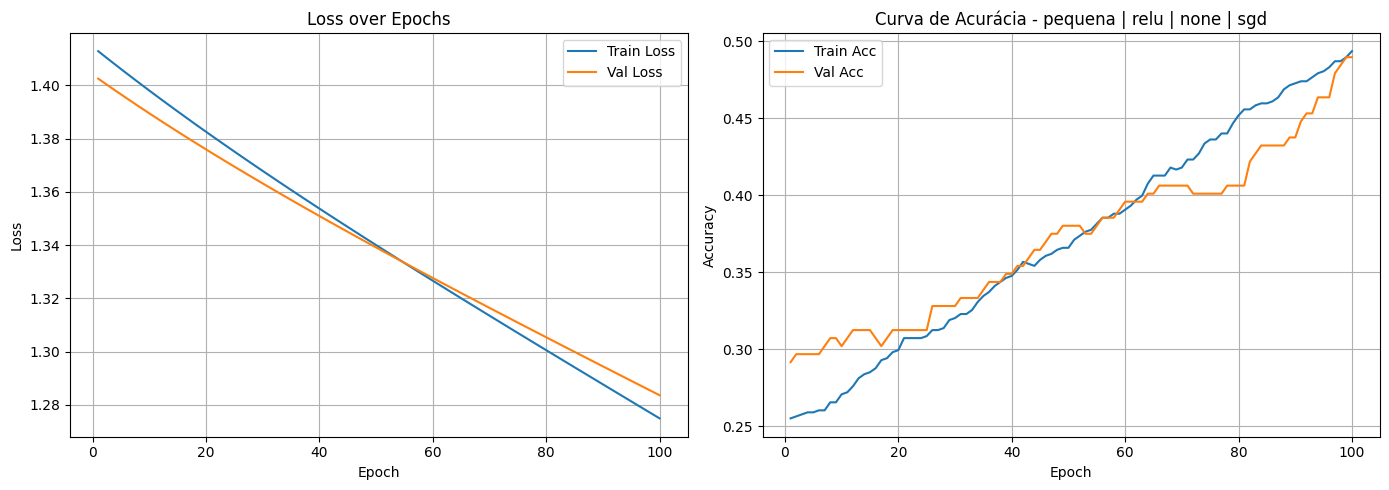

 Conjunto de validação --> Loss: 0.8844, Acurácia: 0.6667
✅ pequena | relu | none | adam => Acc: 0.6625 | Loss: 0.8668


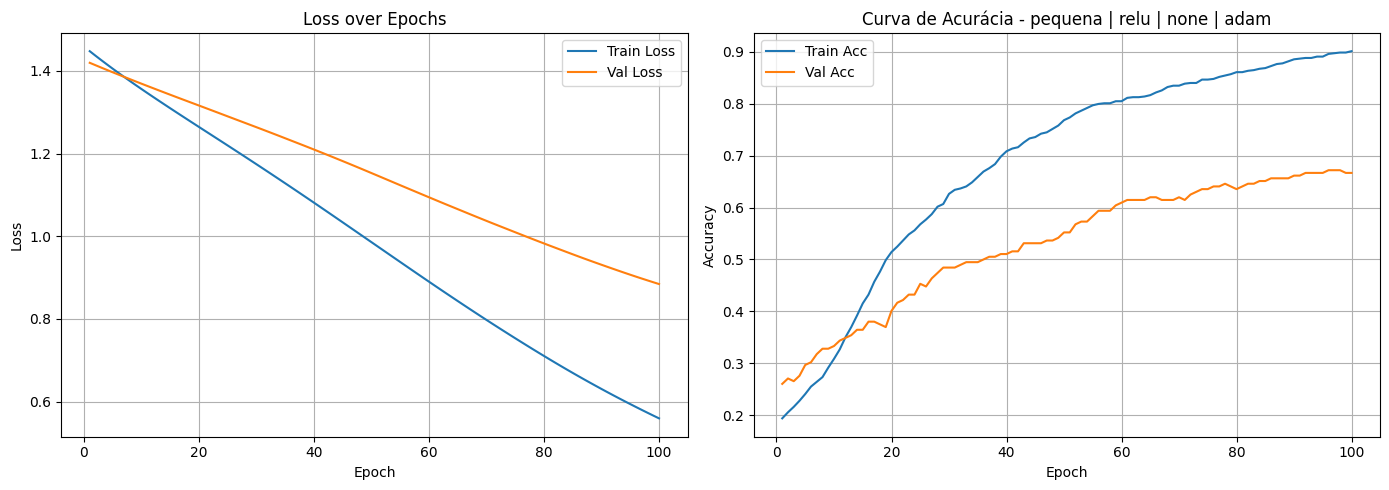

 Conjunto de validação --> Loss: 1.2607, Acurácia: 0.4583
✅ pequena | relu | none | sgd_l2 => Acc: 0.5208 | Loss: 1.2479


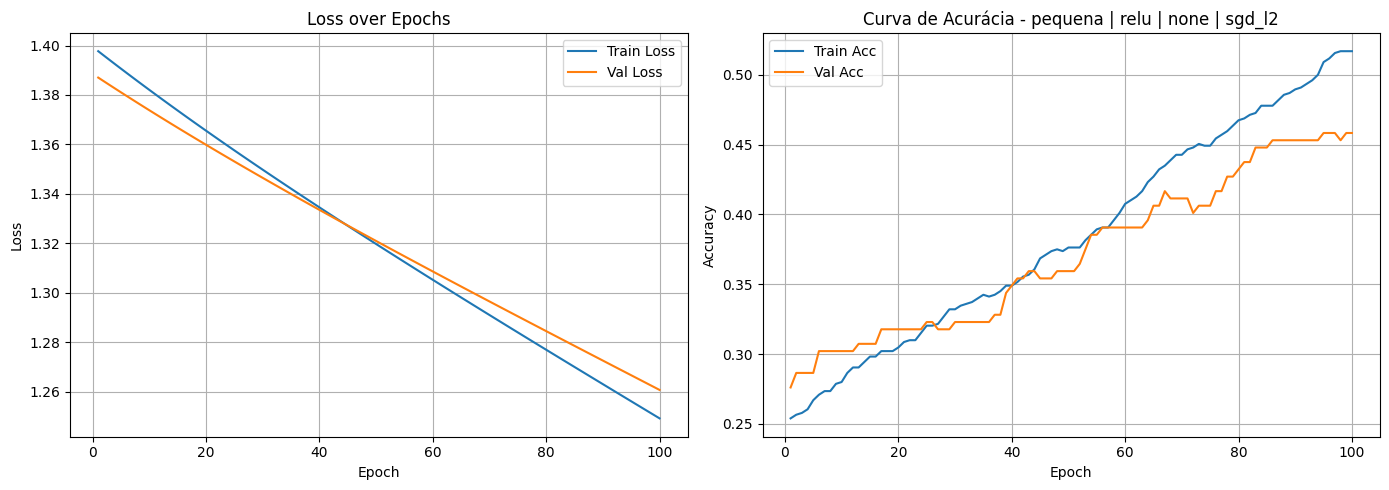

 Conjunto de validação --> Loss: 1.3010, Acurácia: 0.4010
✅ pequena | relu | dropout | sgd => Acc: 0.5208 | Loss: 1.2643


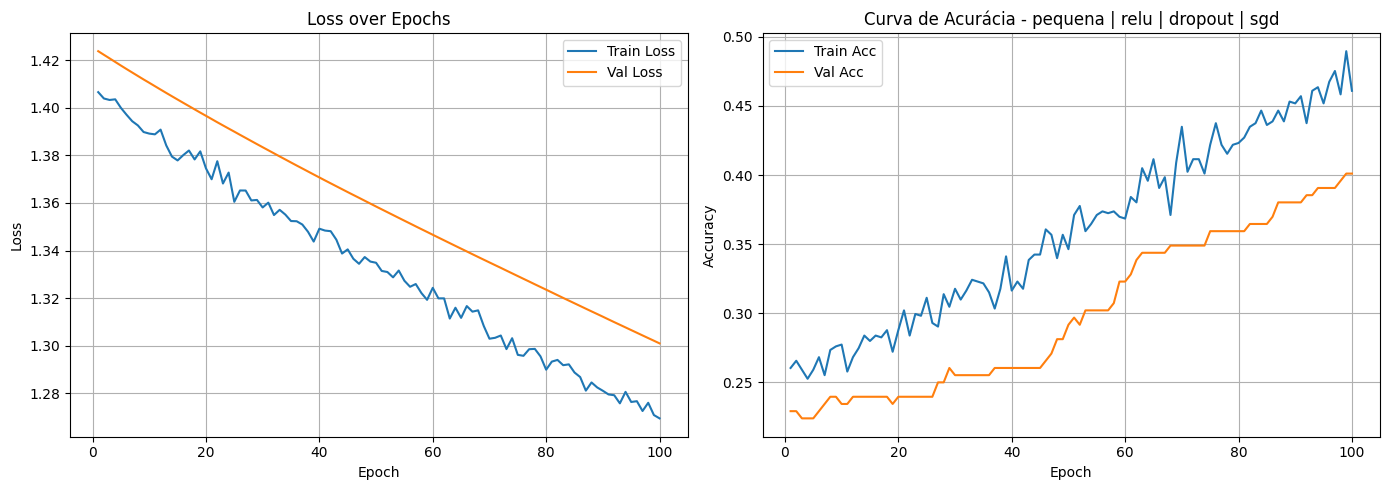

 Conjunto de validação --> Loss: 0.8865, Acurácia: 0.6927
✅ pequena | relu | dropout | adam => Acc: 0.6667 | Loss: 0.8630


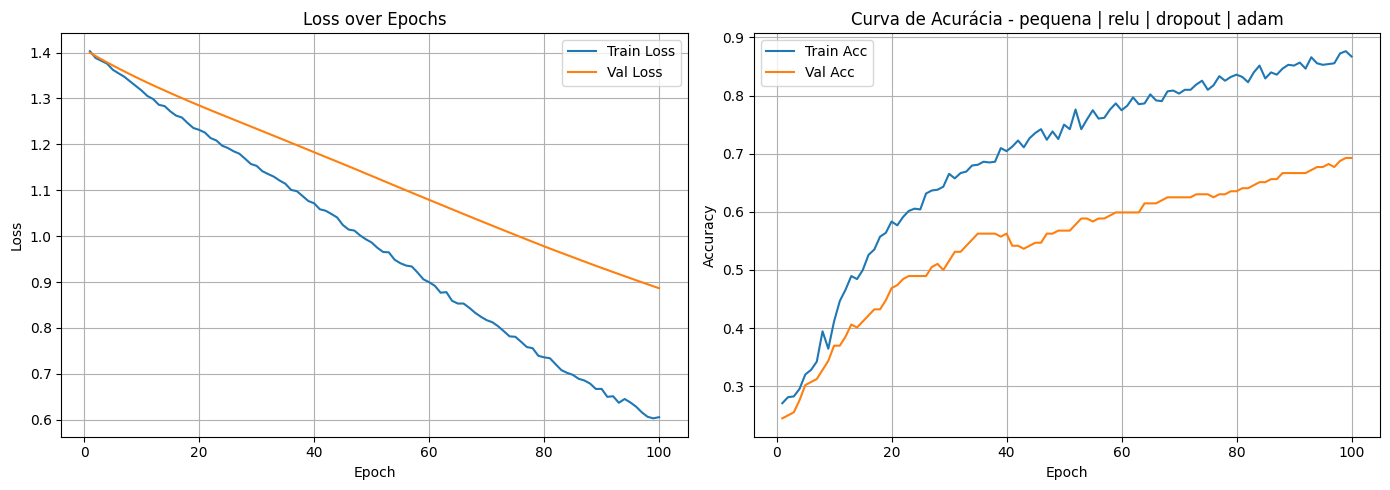

 Conjunto de validação --> Loss: 1.2859, Acurácia: 0.4427
✅ pequena | relu | dropout | sgd_l2 => Acc: 0.4417 | Loss: 1.2669


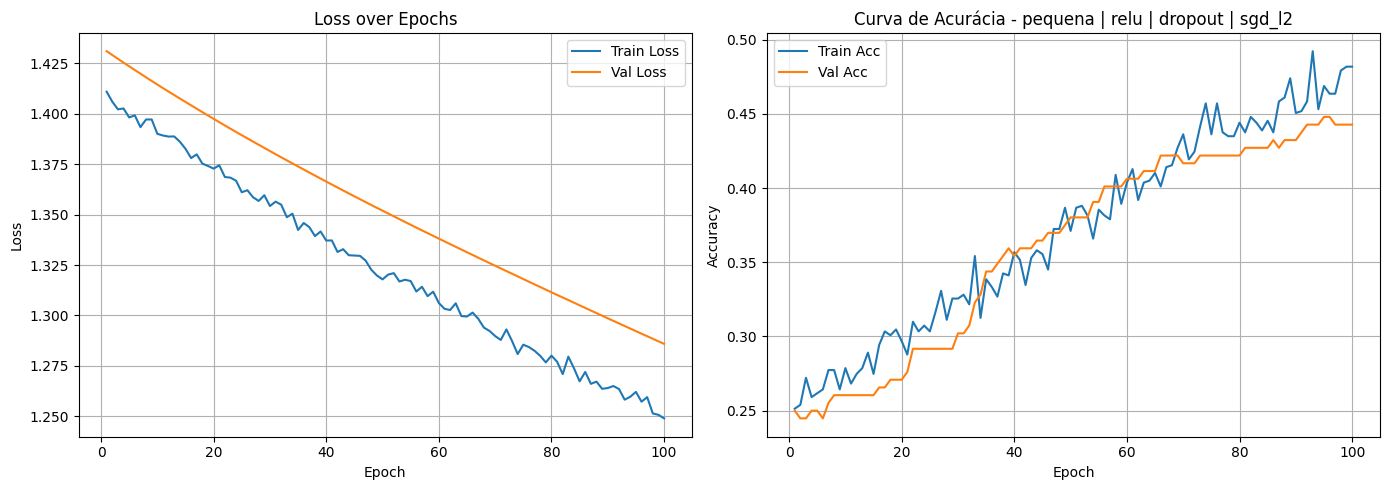

 Conjunto de validação --> Loss: 1.2834, Acurácia: 0.4635
✅ pequena | relu | l2 | sgd => Acc: 0.5042 | Loss: 1.2622


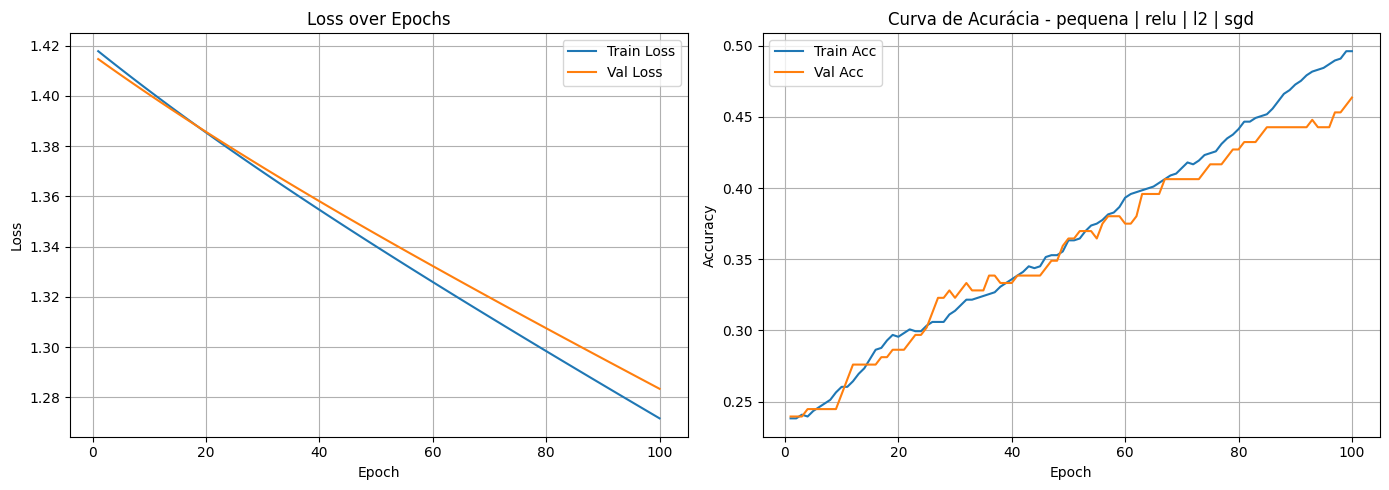

 Conjunto de validação --> Loss: 0.8890, Acurácia: 0.6510
✅ pequena | relu | l2 | adam => Acc: 0.6750 | Loss: 0.8541


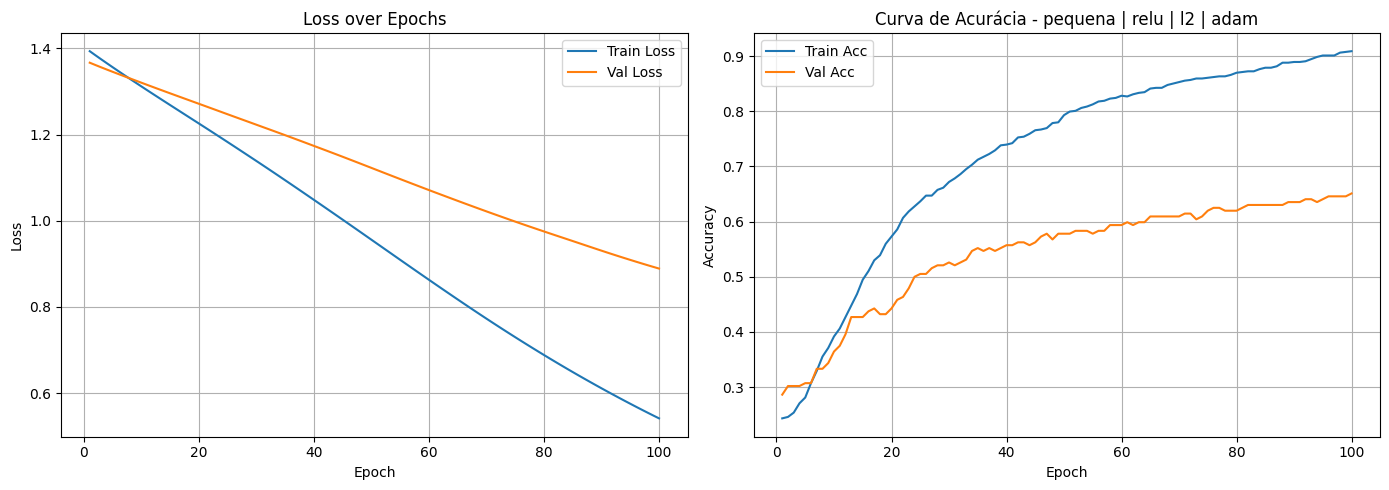

 Conjunto de validação --> Loss: 1.2529, Acurácia: 0.5104
✅ pequena | relu | l2 | sgd_l2 => Acc: 0.5417 | Loss: 1.2431


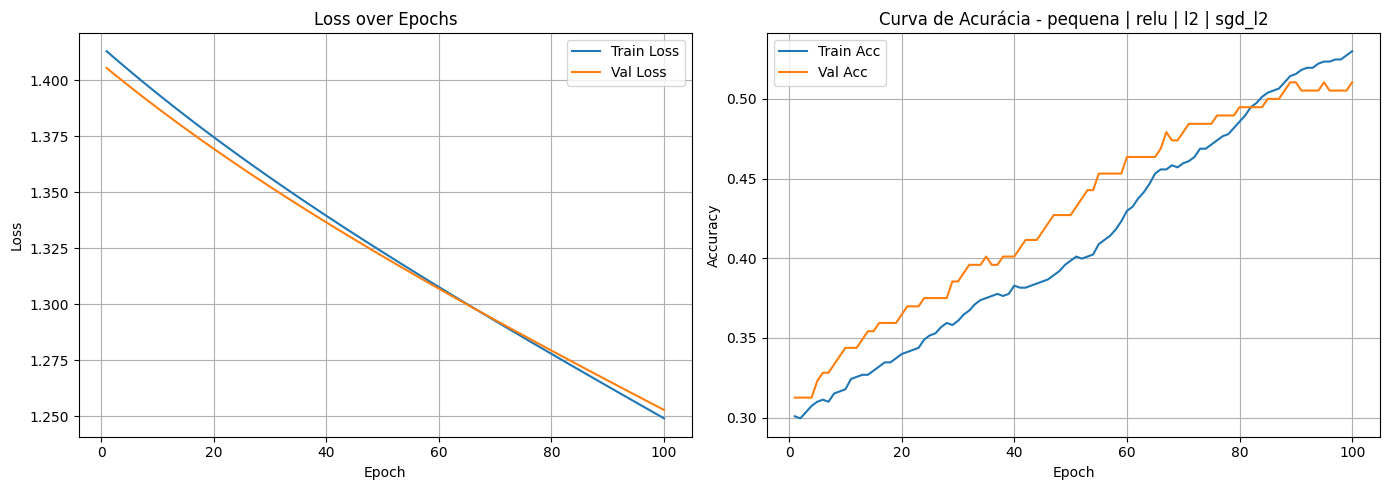

 Conjunto de validação --> Loss: 1.1850, Acurácia: 0.5365
✅ pequena | tanh | none | sgd => Acc: 0.5375 | Loss: 1.1757


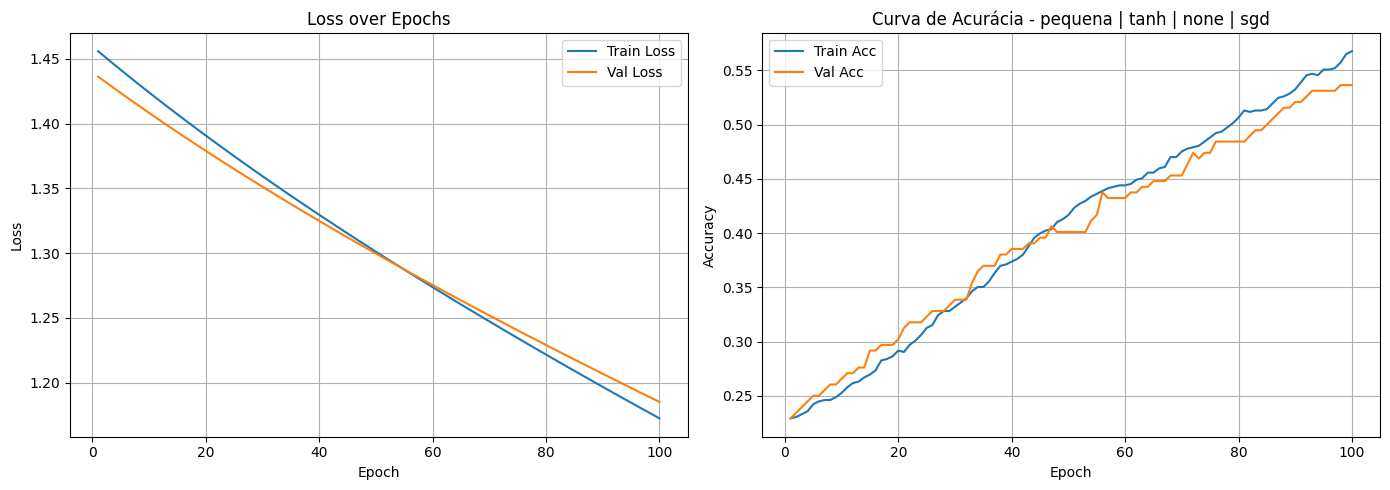

 Conjunto de validação --> Loss: 0.7418, Acurácia: 0.7448
✅ pequena | tanh | none | adam => Acc: 0.7458 | Loss: 0.7413


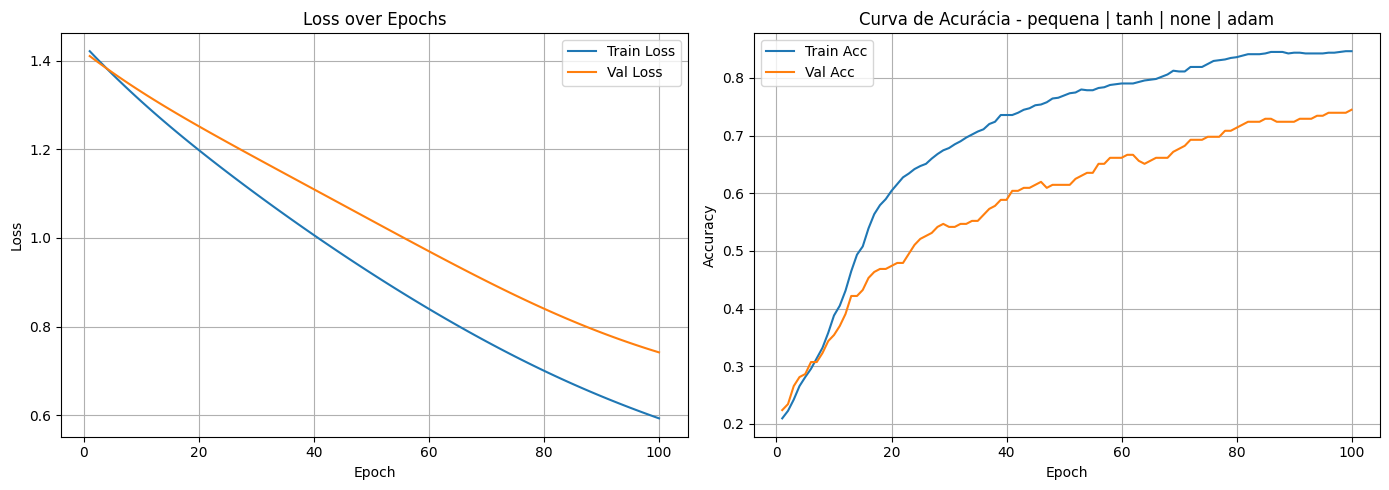

 Conjunto de validação --> Loss: 1.1665, Acurácia: 0.5677
✅ pequena | tanh | none | sgd_l2 => Acc: 0.5500 | Loss: 1.1582


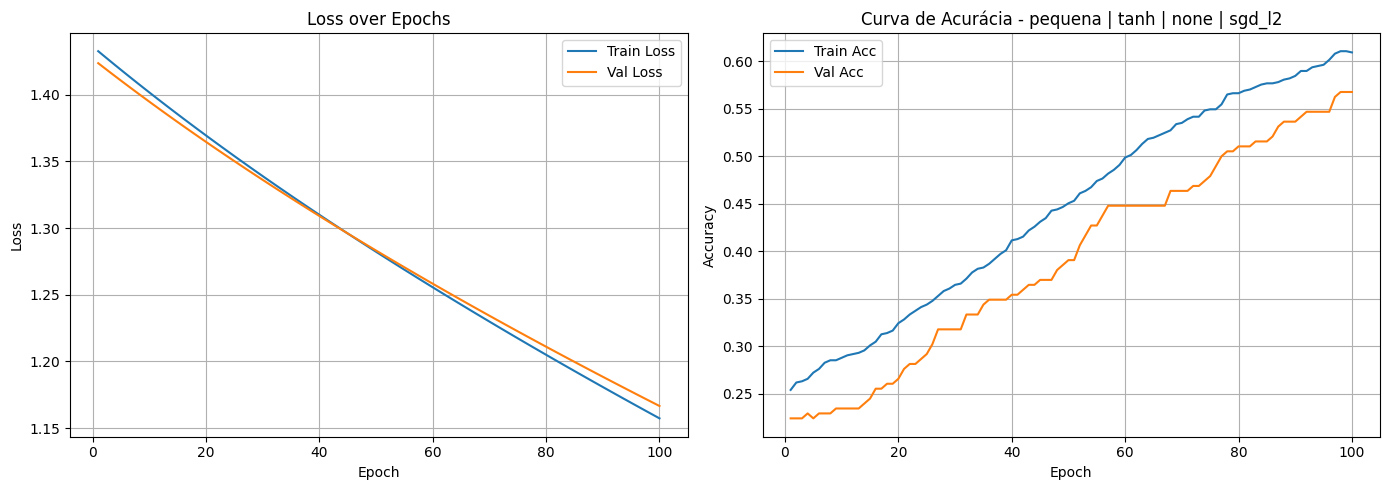

 Conjunto de validação --> Loss: 1.1846, Acurácia: 0.5365
✅ pequena | tanh | dropout | sgd => Acc: 0.5208 | Loss: 1.1833


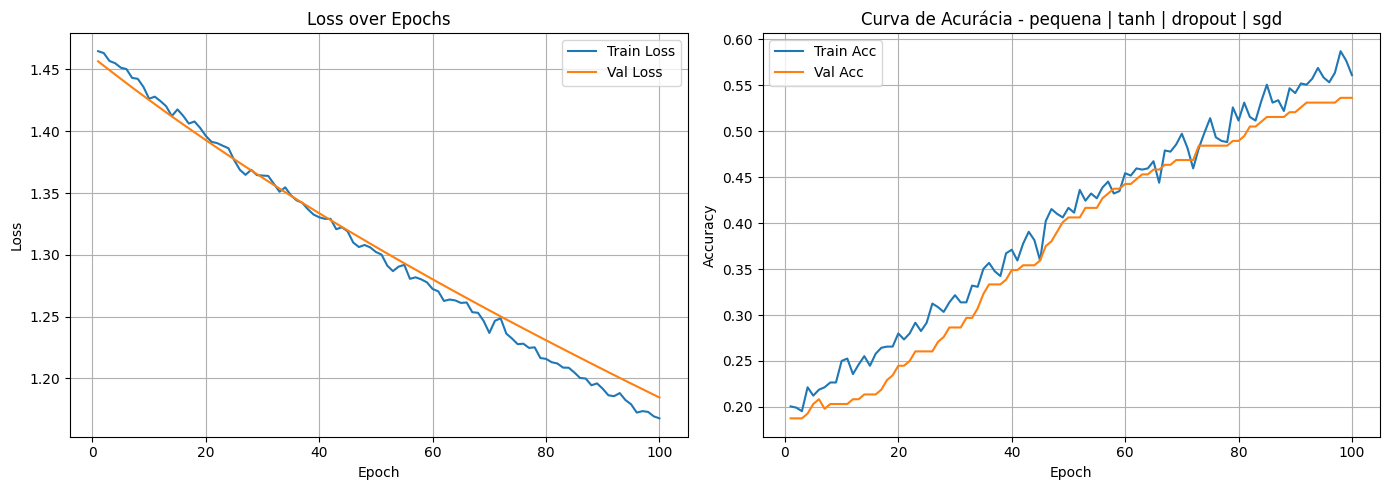

 Conjunto de validação --> Loss: 0.7508, Acurácia: 0.7344
✅ pequena | tanh | dropout | adam => Acc: 0.7375 | Loss: 0.7392


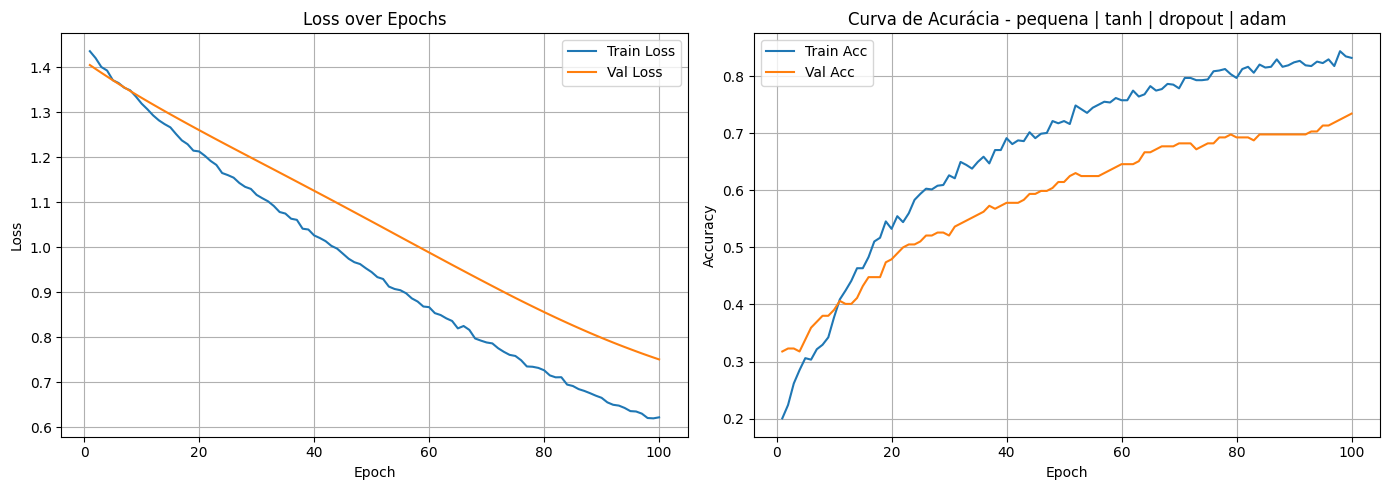

 Conjunto de validação --> Loss: 1.1973, Acurácia: 0.5208
✅ pequena | tanh | dropout | sgd_l2 => Acc: 0.5458 | Loss: 1.1682


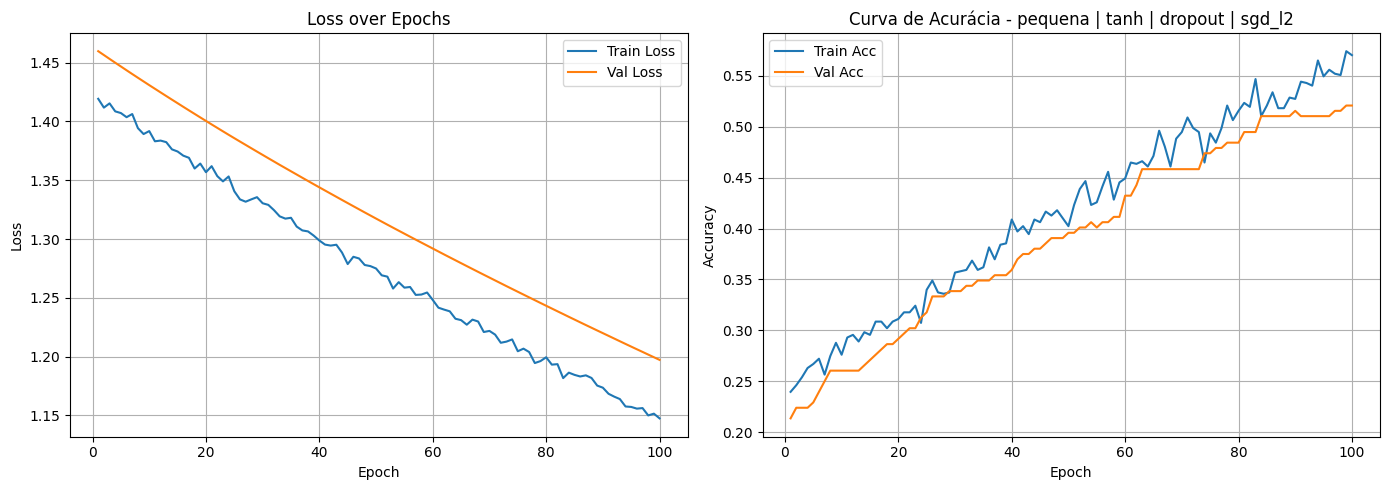

 Conjunto de validação --> Loss: 1.1525, Acurácia: 0.5625
✅ pequena | tanh | l2 | sgd => Acc: 0.6125 | Loss: 1.1039


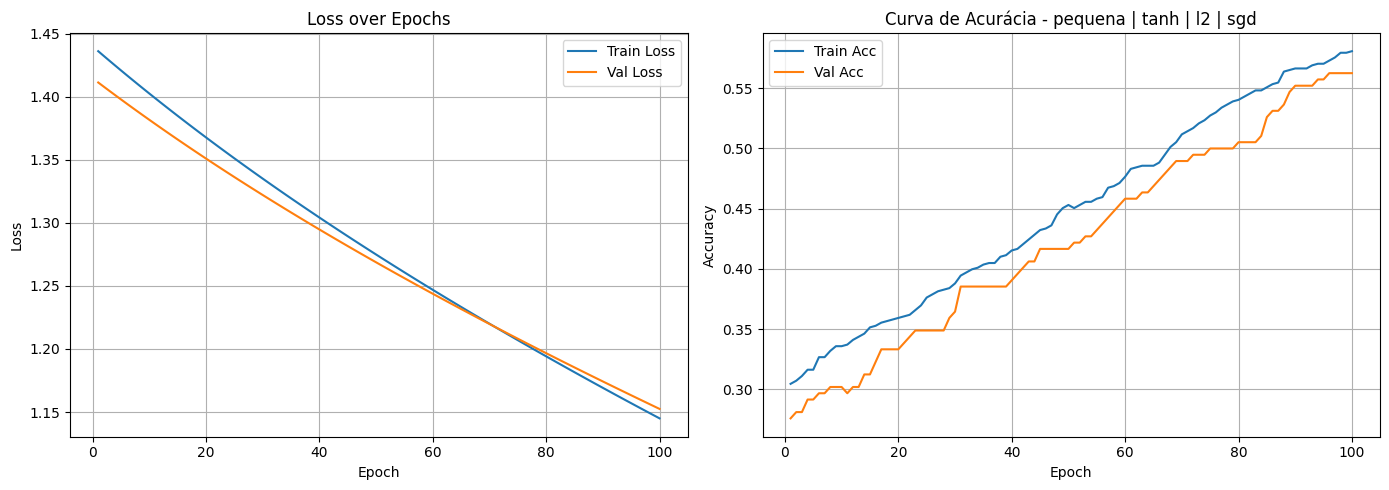

 Conjunto de validação --> Loss: 0.7496, Acurácia: 0.7240
✅ pequena | tanh | l2 | adam => Acc: 0.7542 | Loss: 0.7361


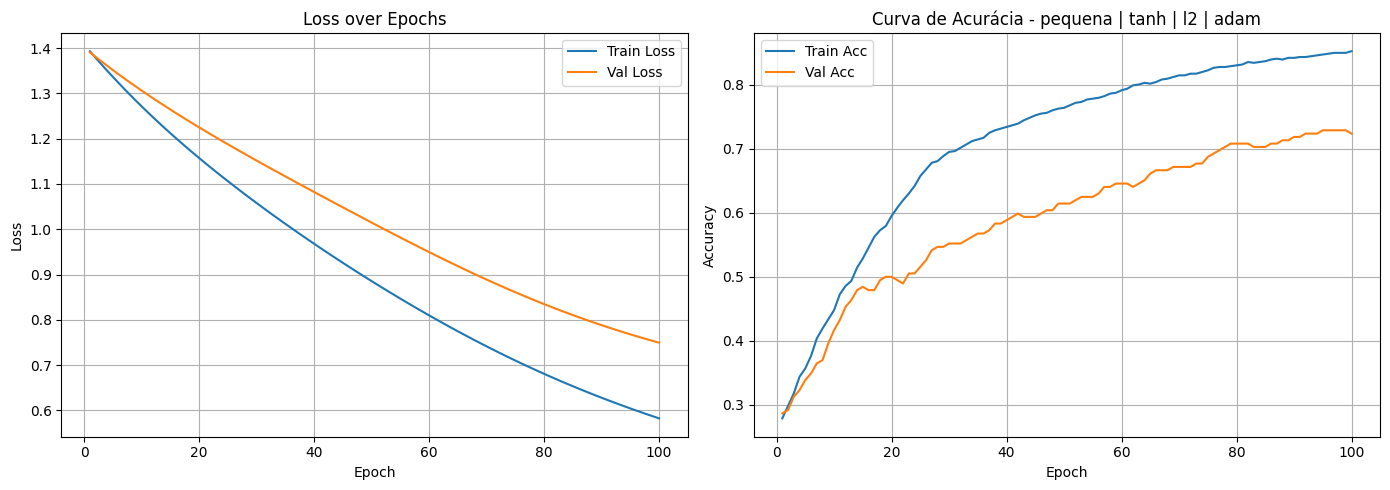

 Conjunto de validação --> Loss: 1.1421, Acurácia: 0.6302
✅ pequena | tanh | l2 | sgd_l2 => Acc: 0.5458 | Loss: 1.1598


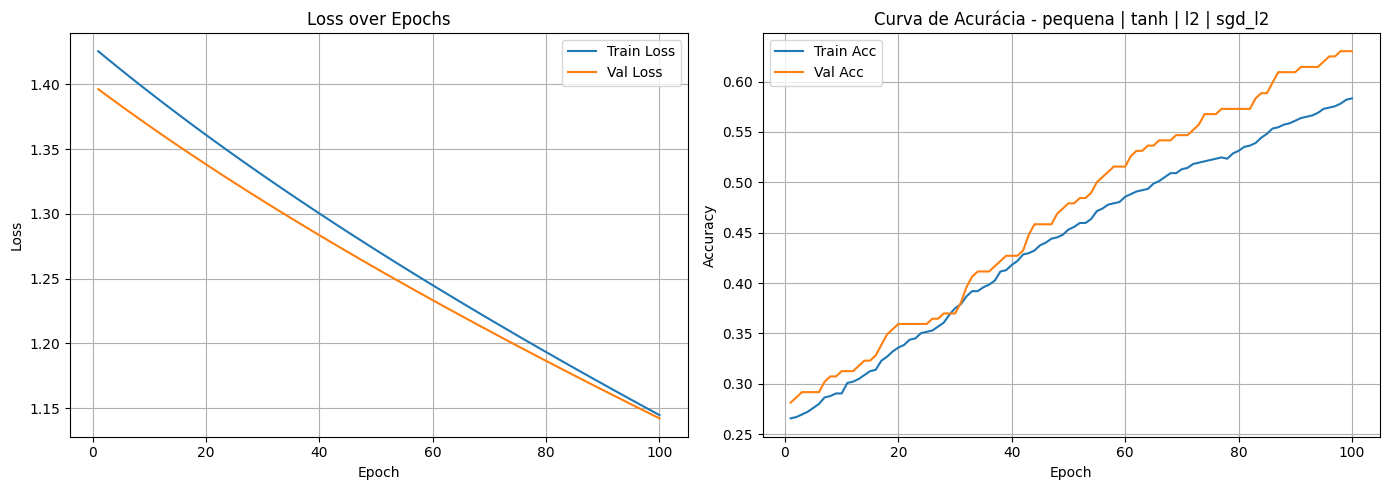

 Conjunto de validação --> Loss: 1.3618, Acurácia: 0.3958
✅ media | relu | none | sgd => Acc: 0.3333 | Loss: 1.3622


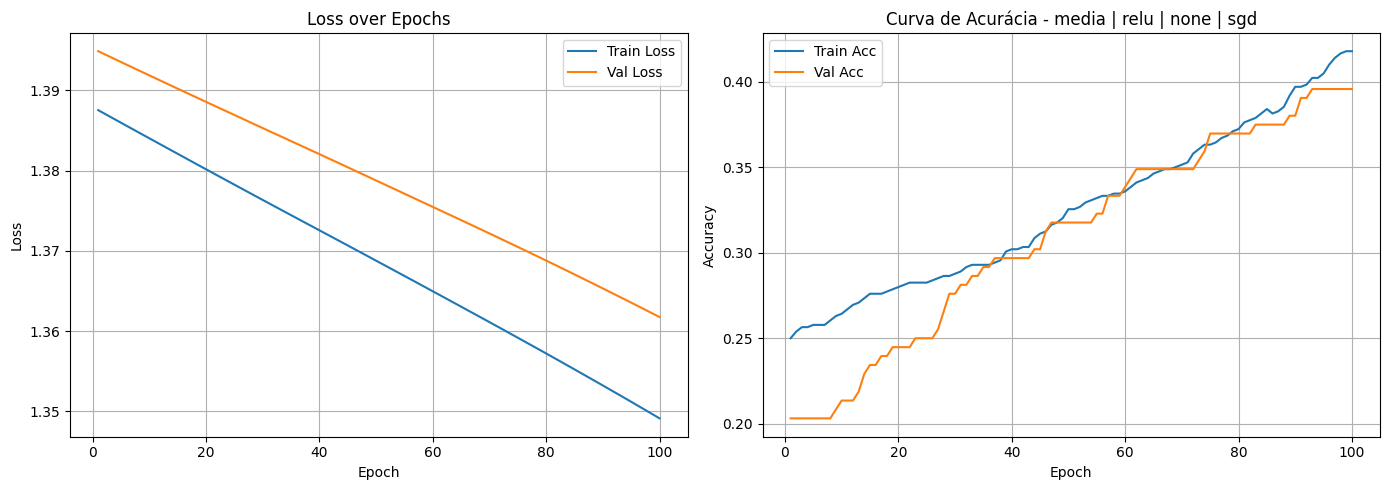

Early stopping triggered.
 Conjunto de validação --> Loss: 0.6442, Acurácia: 0.7552
✅ media | relu | none | adam => Acc: 0.7667 | Loss: 0.6677


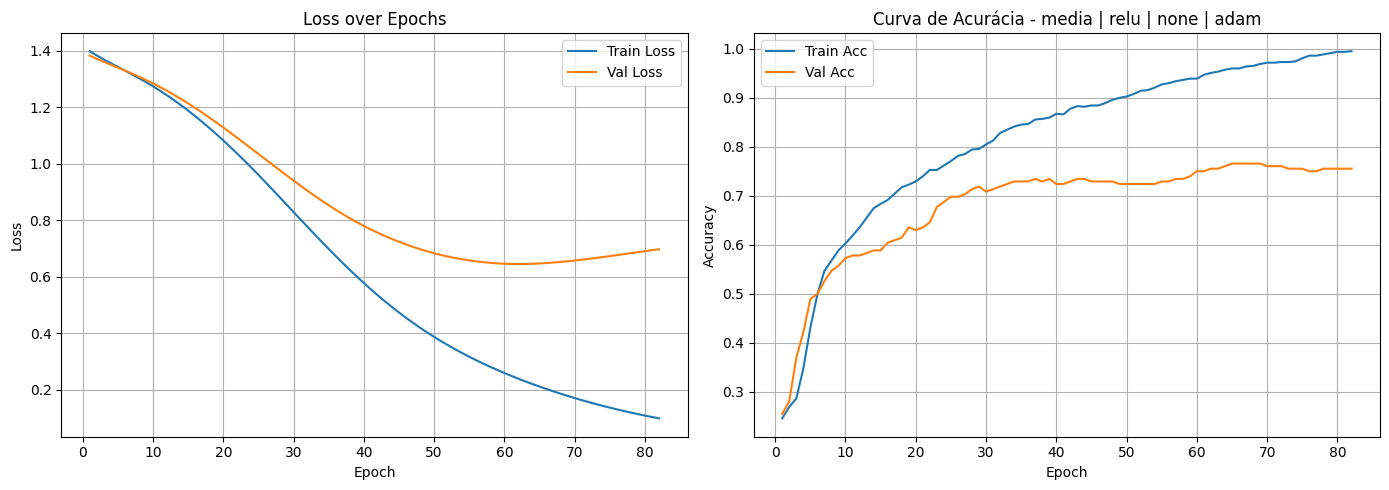

 Conjunto de validação --> Loss: 1.3491, Acurácia: 0.3802
✅ media | relu | none | sgd_l2 => Acc: 0.4167 | Loss: 1.3462


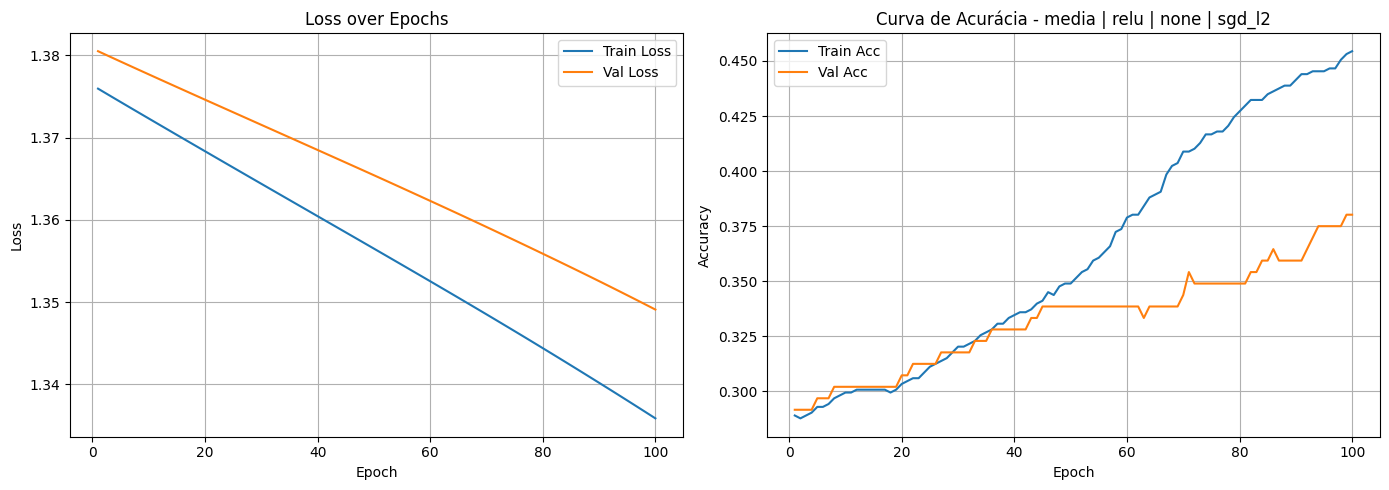

 Conjunto de validação --> Loss: 1.3586, Acurácia: 0.3229
✅ media | relu | dropout | sgd => Acc: 0.3708 | Loss: 1.3514


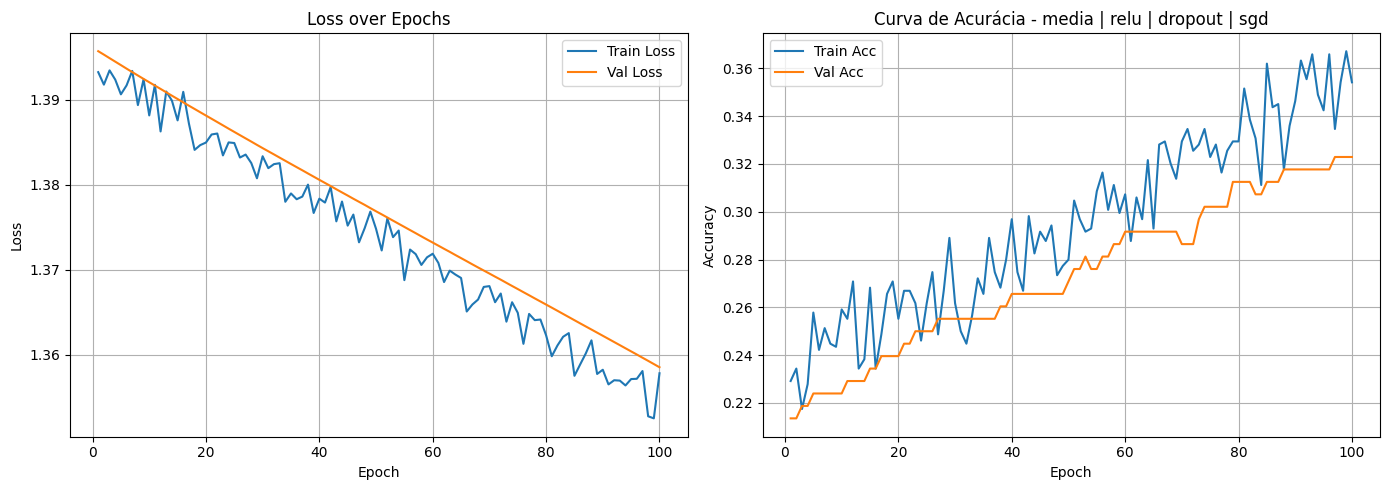

Early stopping triggered.
 Conjunto de validação --> Loss: 0.6269, Acurácia: 0.7552
✅ media | relu | dropout | adam => Acc: 0.7958 | Loss: 0.7429


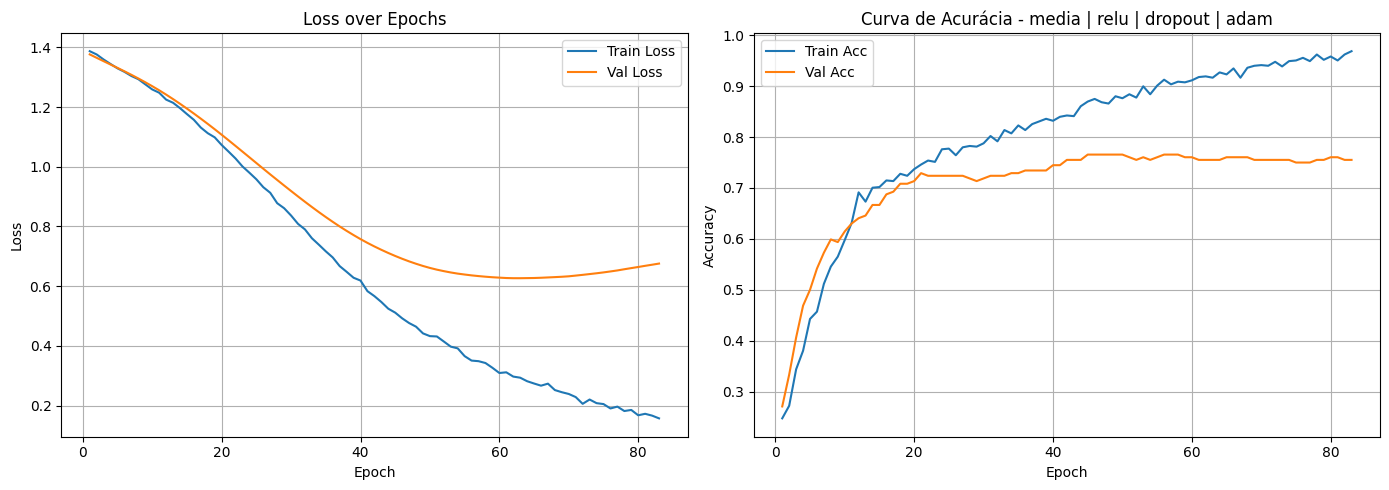

 Conjunto de validação --> Loss: 1.3511, Acurácia: 0.3854
✅ media | relu | dropout | sgd_l2 => Acc: 0.4083 | Loss: 1.3430


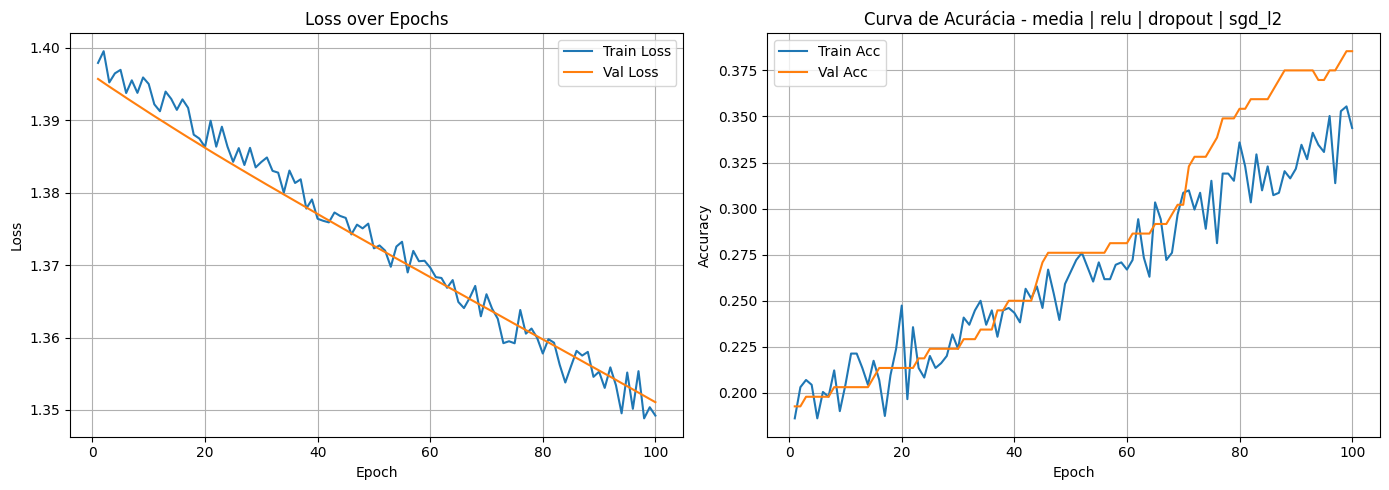

 Conjunto de validação --> Loss: 1.3685, Acurácia: 0.2865
✅ media | relu | l2 | sgd => Acc: 0.3625 | Loss: 1.3619


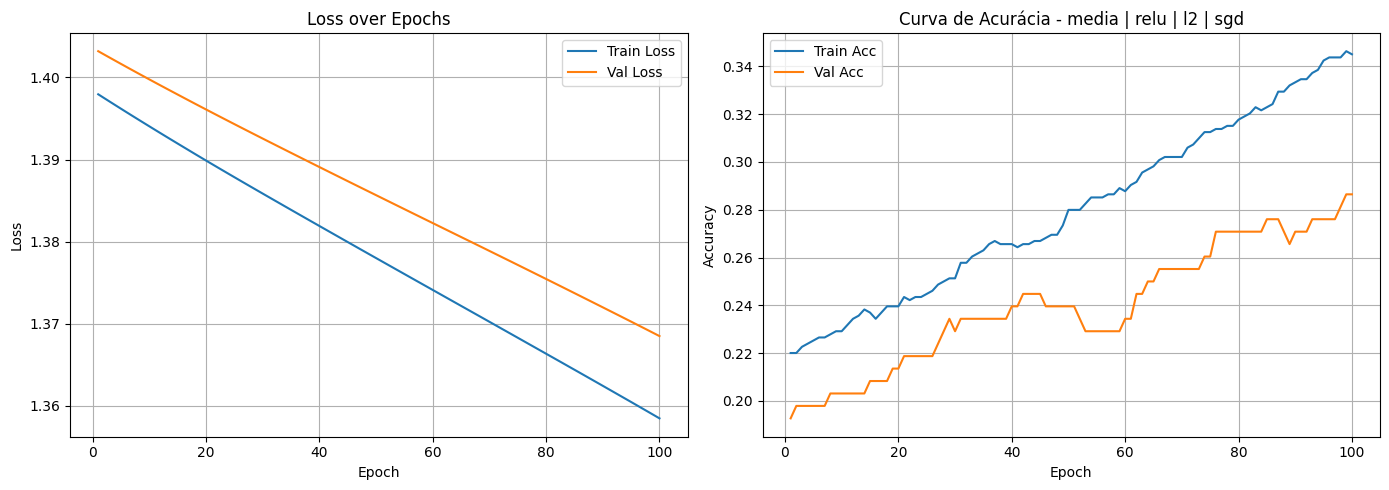

Early stopping triggered.
 Conjunto de validação --> Loss: 0.6255, Acurácia: 0.7656
✅ media | relu | l2 | adam => Acc: 0.7792 | Loss: 0.7270


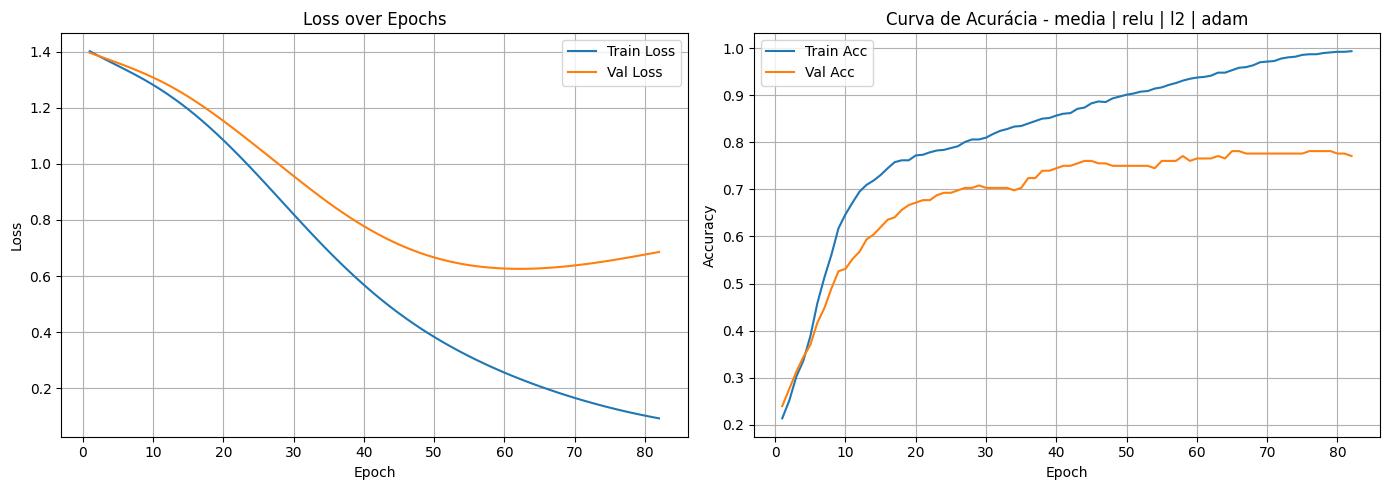

 Conjunto de validação --> Loss: 1.3512, Acurácia: 0.4688
✅ media | relu | l2 | sgd_l2 => Acc: 0.4417 | Loss: 1.3552


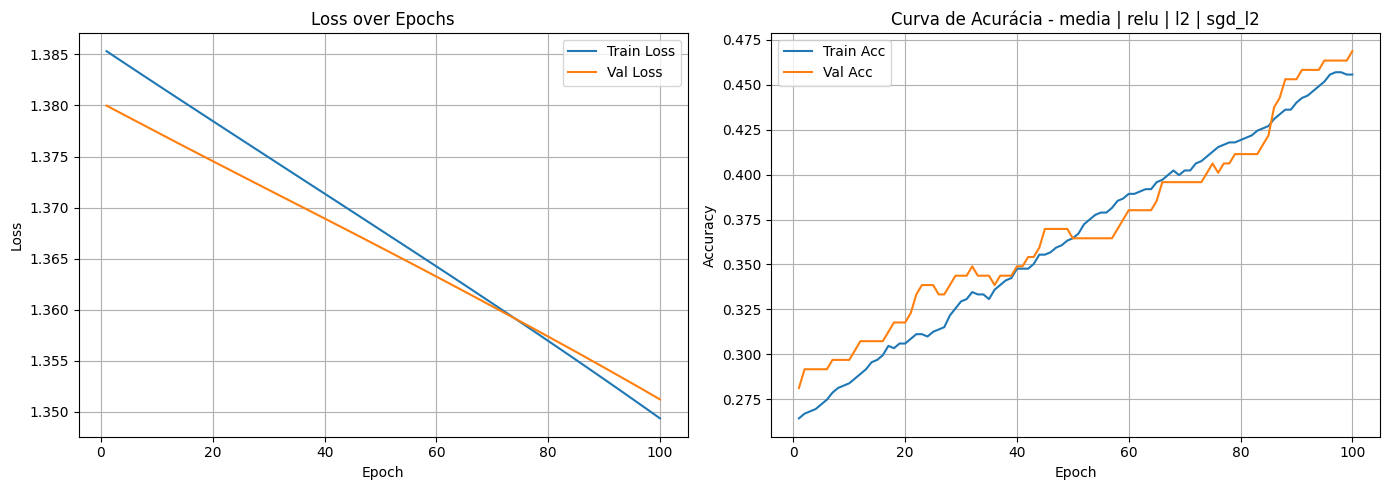

 Conjunto de validação --> Loss: 1.2181, Acurácia: 0.6719
✅ media | tanh | none | sgd => Acc: 0.6375 | Loss: 1.2082


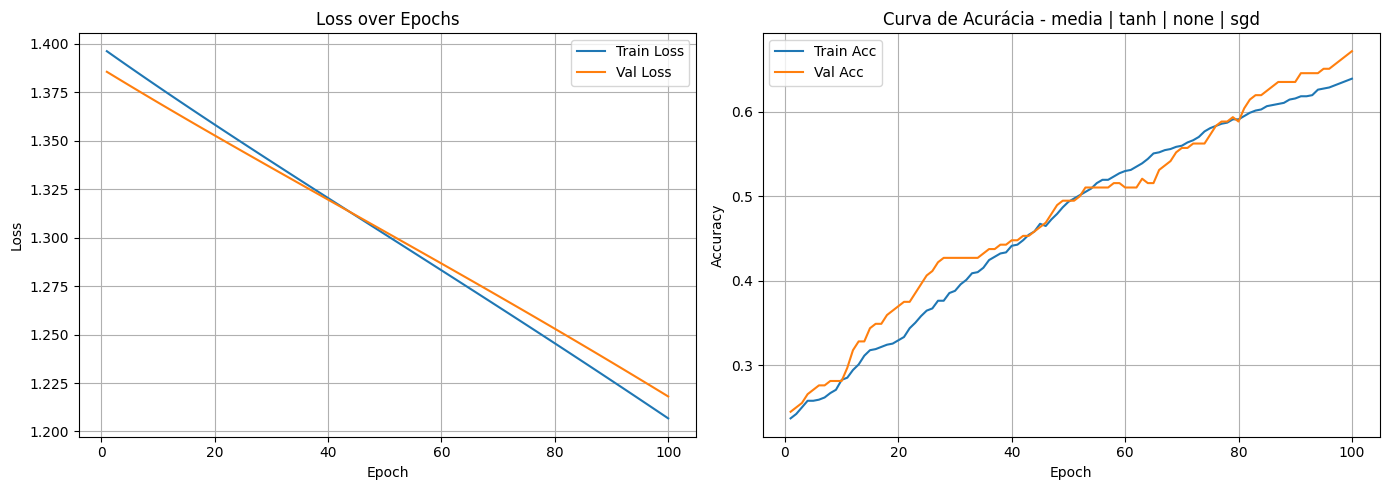

Early stopping triggered.
 Conjunto de validação --> Loss: 0.5994, Acurácia: 0.7760
✅ media | tanh | none | adam => Acc: 0.7792 | Loss: 0.6713


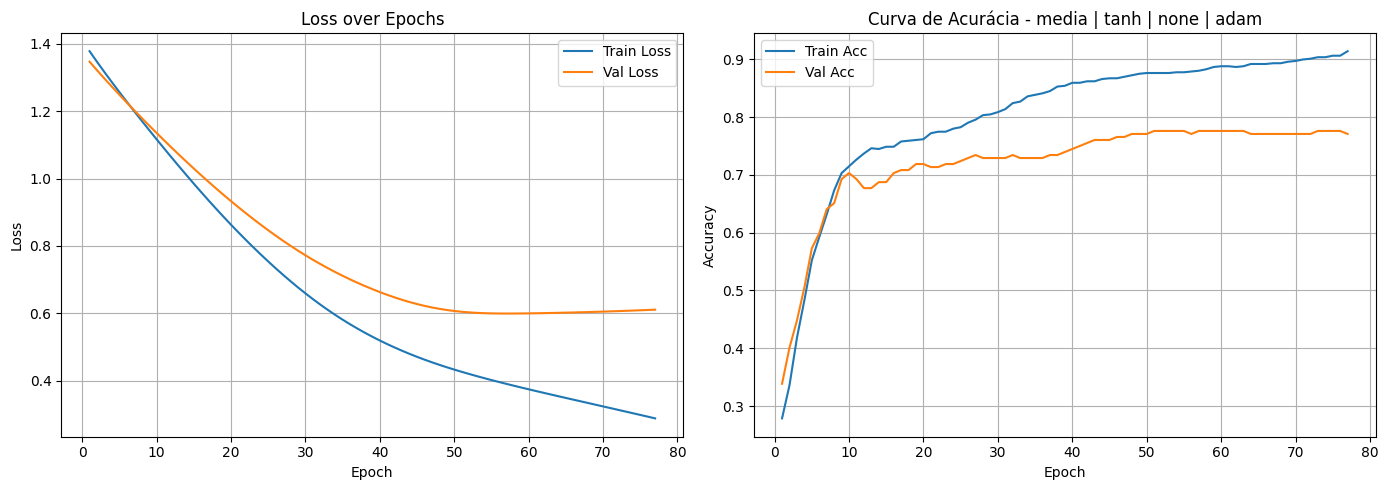

 Conjunto de validação --> Loss: 1.2094, Acurácia: 0.5521
✅ media | tanh | none | sgd_l2 => Acc: 0.5833 | Loss: 1.1995


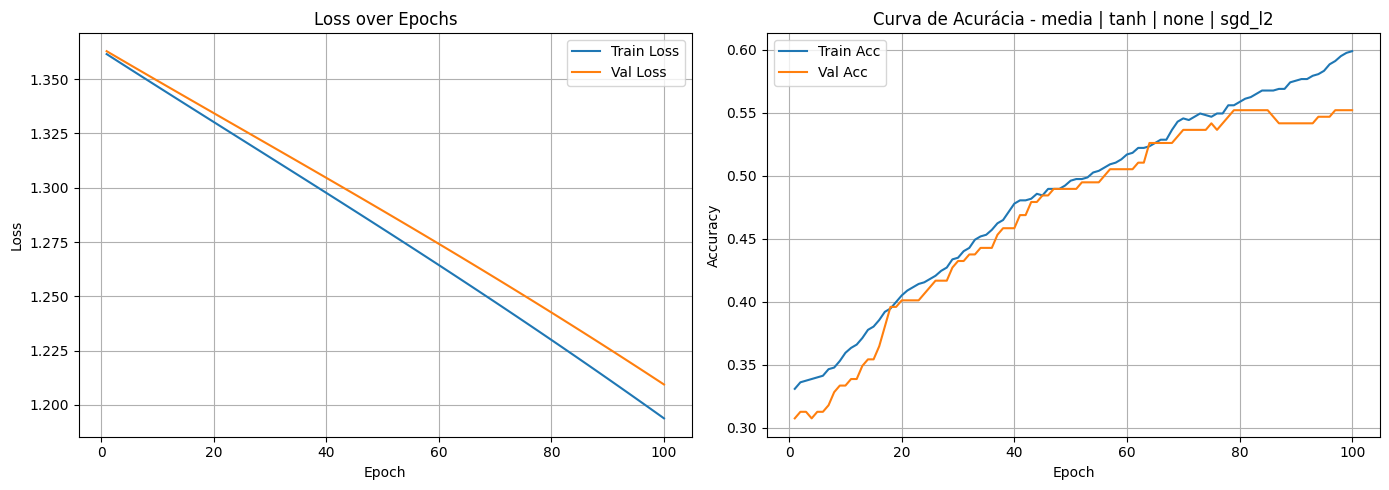

 Conjunto de validação --> Loss: 1.2109, Acurácia: 0.6198
✅ media | tanh | dropout | sgd => Acc: 0.6083 | Loss: 1.1961


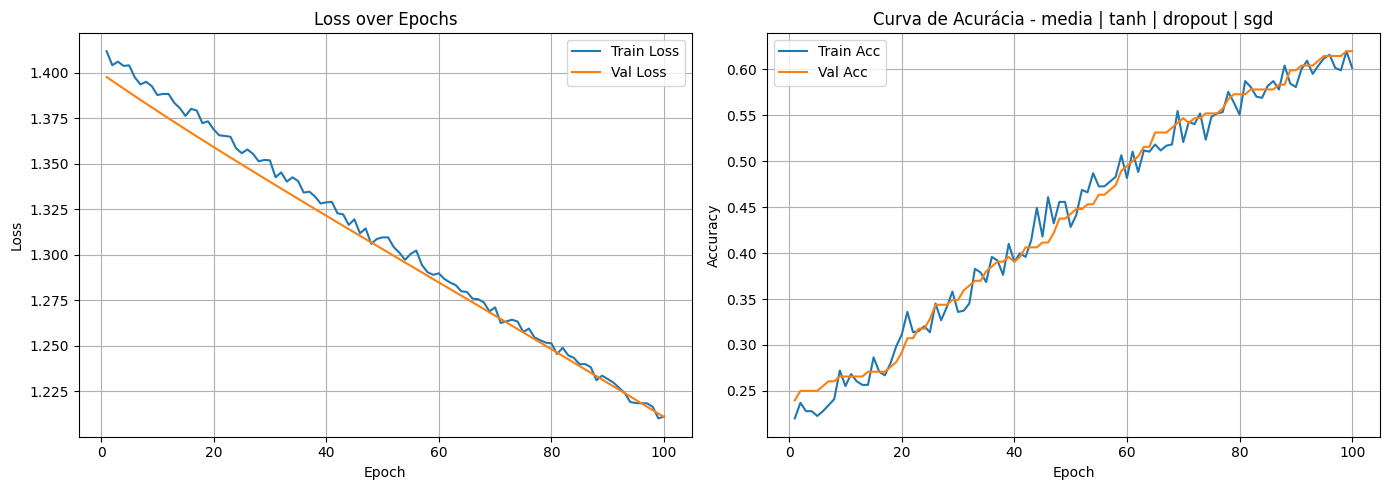

Early stopping triggered.
 Conjunto de validação --> Loss: 0.5900, Acurácia: 0.7708
✅ media | tanh | dropout | adam => Acc: 0.7792 | Loss: 0.6349


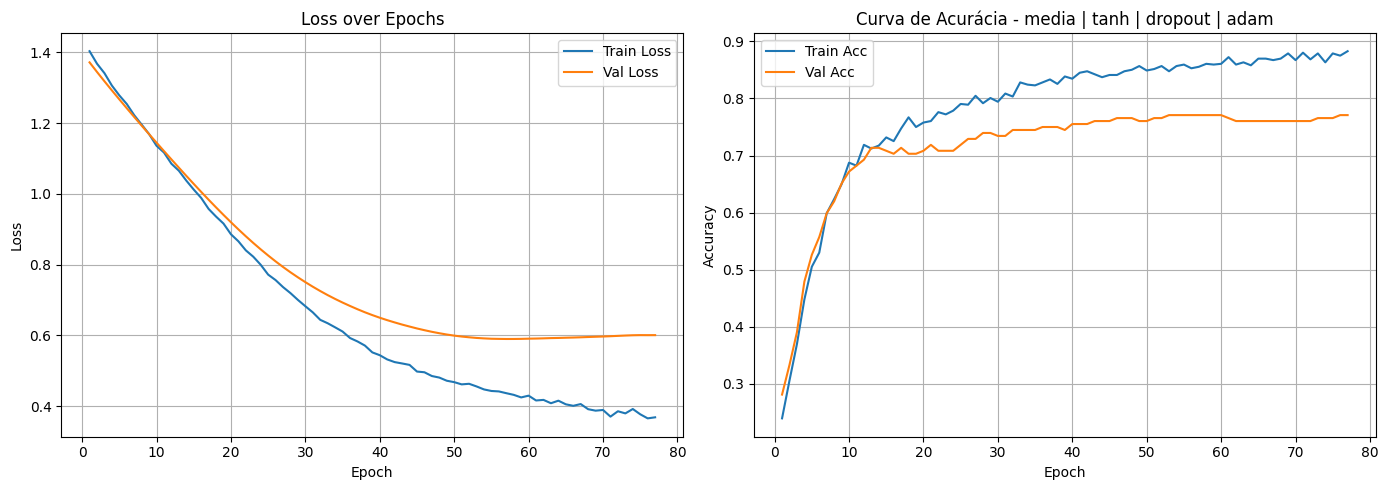

 Conjunto de validação --> Loss: 1.2578, Acurácia: 0.4948
✅ media | tanh | dropout | sgd_l2 => Acc: 0.6083 | Loss: 1.2217


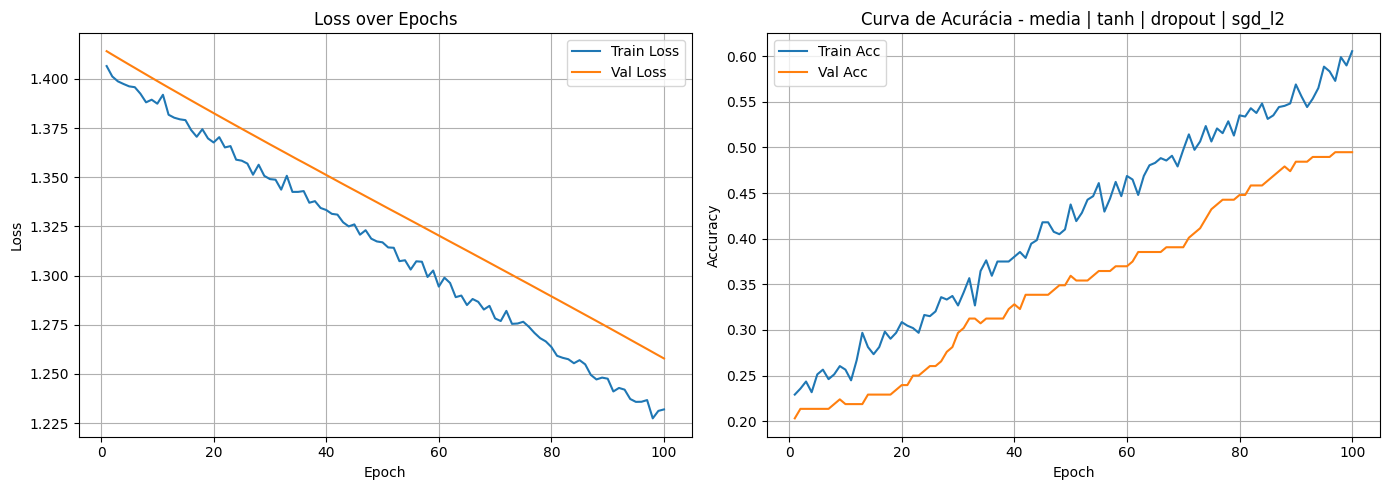

 Conjunto de validação --> Loss: 1.2095, Acurácia: 0.5990
✅ media | tanh | l2 | sgd => Acc: 0.6417 | Loss: 1.1806


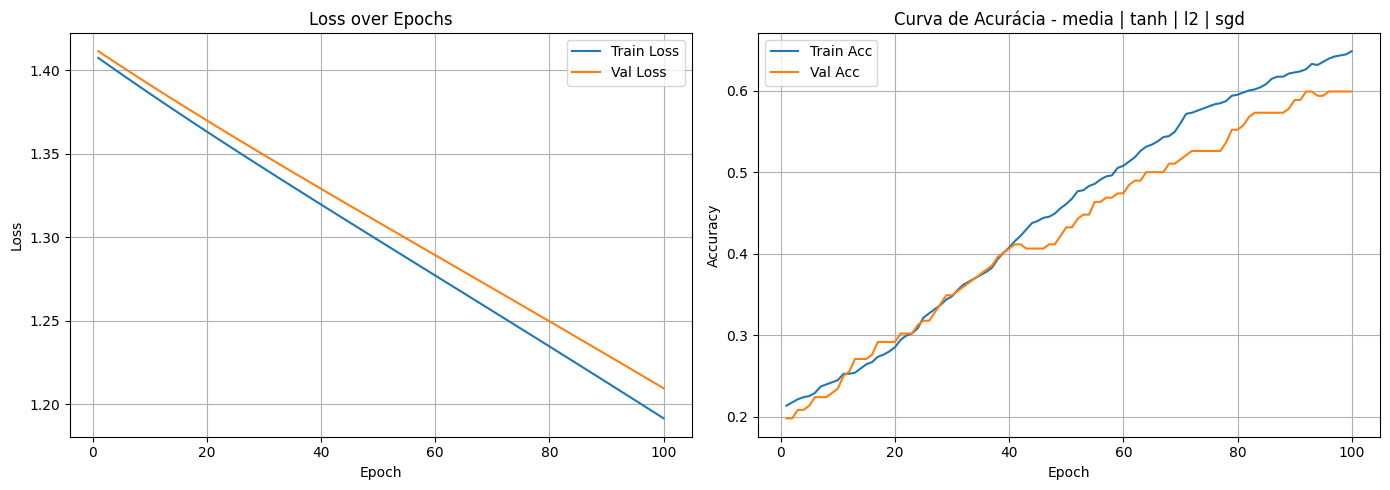

Early stopping triggered.
 Conjunto de validação --> Loss: 0.5916, Acurácia: 0.7812
✅ media | tanh | l2 | adam => Acc: 0.7875 | Loss: 0.6238


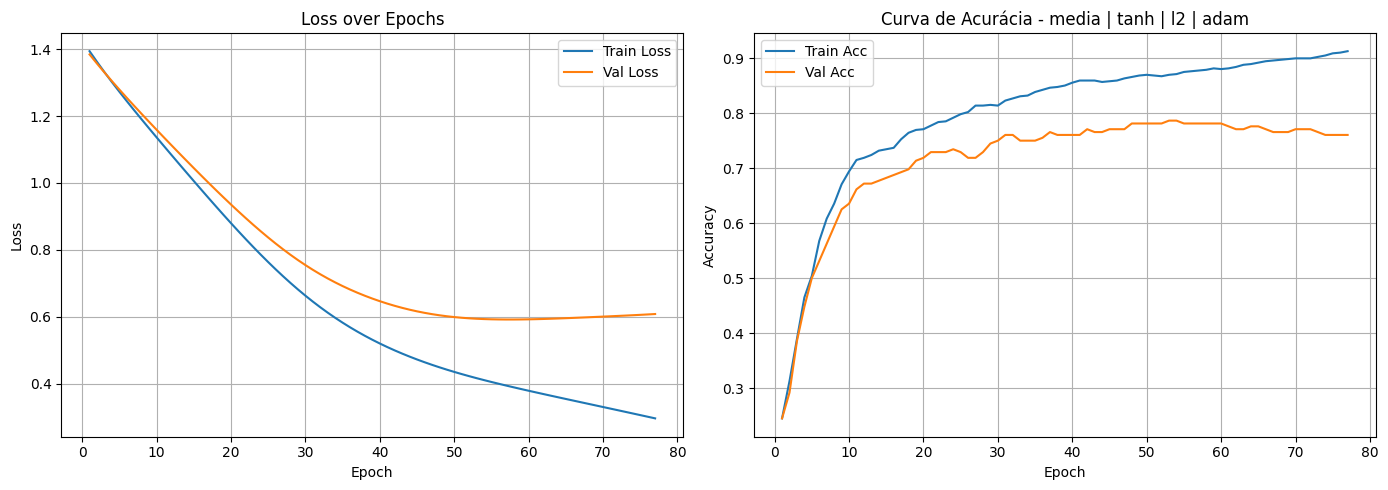

 Conjunto de validação --> Loss: 1.2420, Acurácia: 0.5729
✅ media | tanh | l2 | sgd_l2 => Acc: 0.6208 | Loss: 1.2135


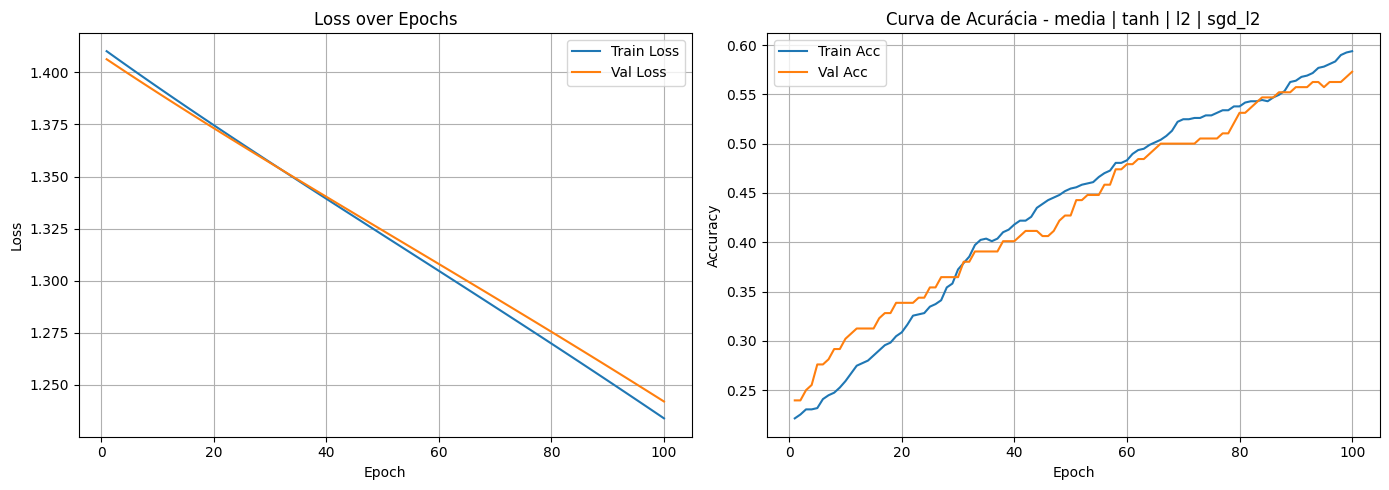

 Conjunto de validação --> Loss: 1.3792, Acurácia: 0.3125
✅ grande | relu | none | sgd => Acc: 0.3625 | Loss: 1.3756


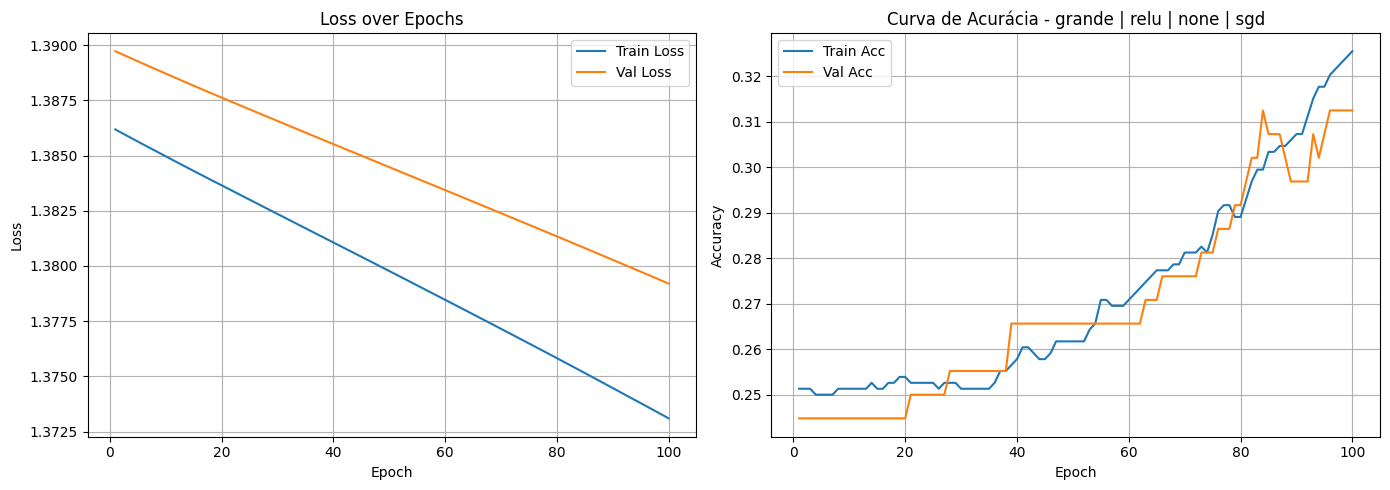

Early stopping triggered.
 Conjunto de validação --> Loss: 0.5975, Acurácia: 0.7760
✅ grande | relu | none | adam => Acc: 0.7875 | Loss: 0.8357


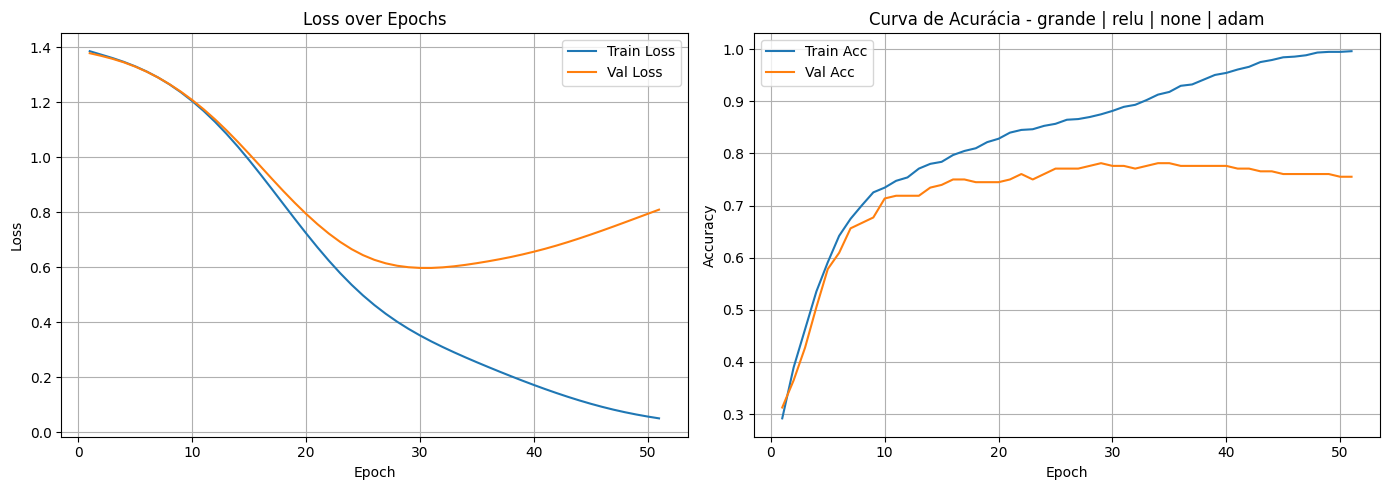

 Conjunto de validação --> Loss: 1.3757, Acurácia: 0.3646
✅ grande | relu | none | sgd_l2 => Acc: 0.3333 | Loss: 1.3764


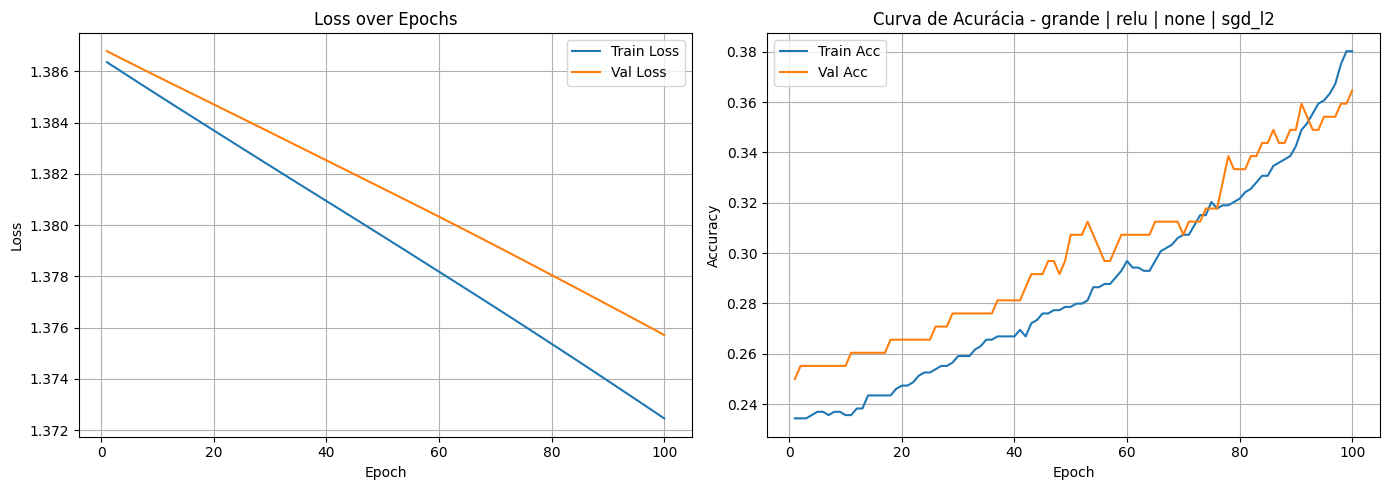

 Conjunto de validação --> Loss: 1.3746, Acurácia: 0.3594
✅ grande | relu | dropout | sgd => Acc: 0.4292 | Loss: 1.3703


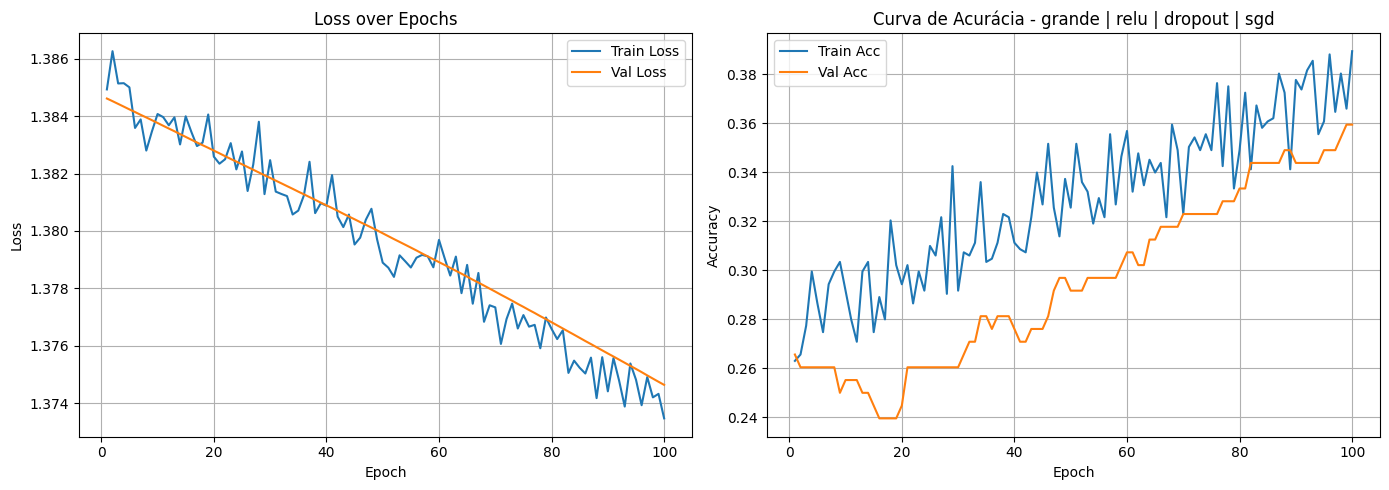

Early stopping triggered.
 Conjunto de validação --> Loss: 0.6374, Acurácia: 0.7865
✅ grande | relu | dropout | adam => Acc: 0.7875 | Loss: 0.7876


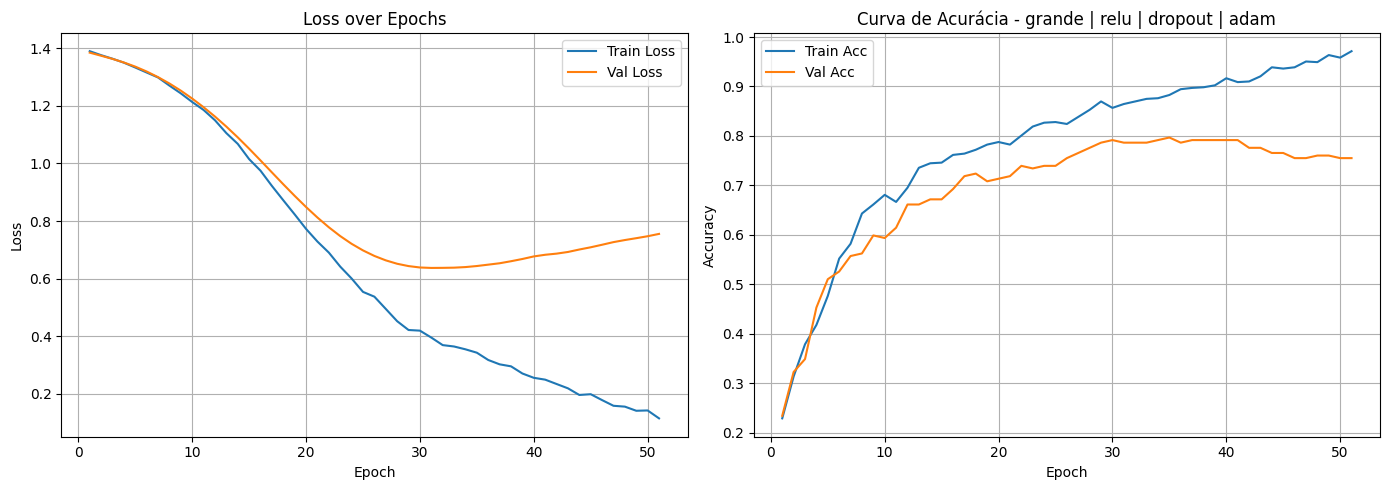

 Conjunto de validação --> Loss: 1.3815, Acurácia: 0.2448
✅ grande | relu | dropout | sgd_l2 => Acc: 0.2375 | Loss: 1.3814


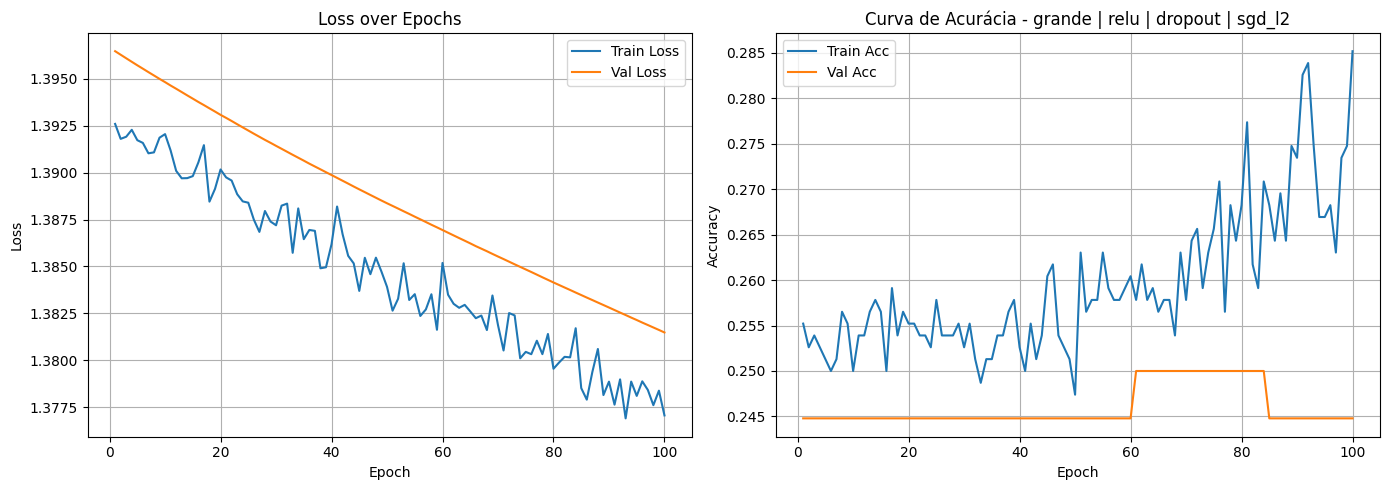

 Conjunto de validação --> Loss: 1.3844, Acurácia: 0.2969
✅ grande | relu | l2 | sgd => Acc: 0.2750 | Loss: 1.3841


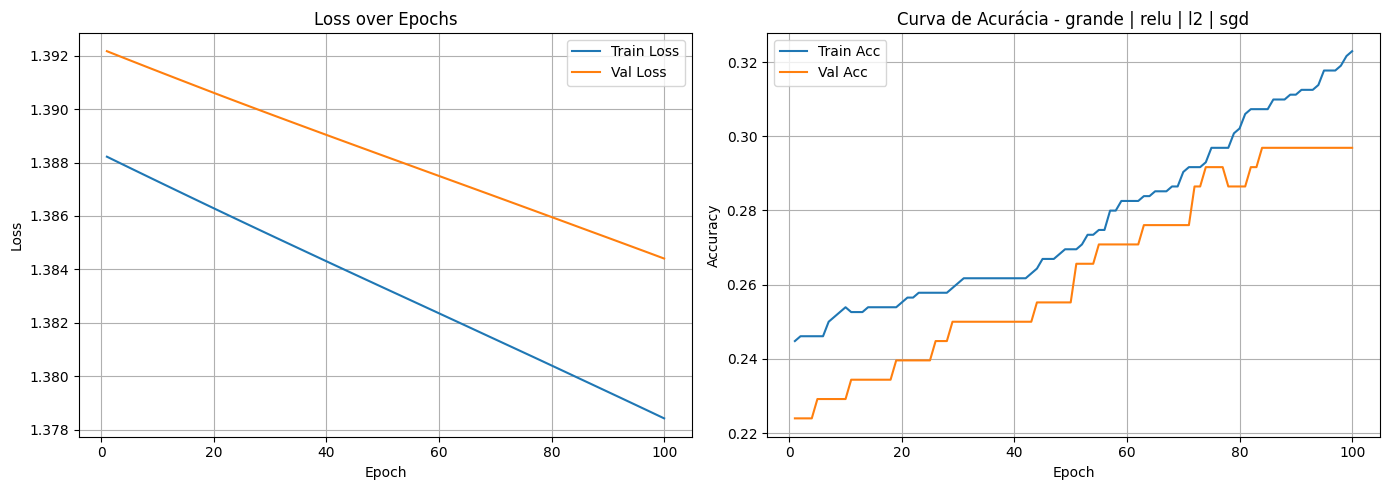

Early stopping triggered.
 Conjunto de validação --> Loss: 0.6031, Acurácia: 0.7969
✅ grande | relu | l2 | adam => Acc: 0.7792 | Loss: 0.8952


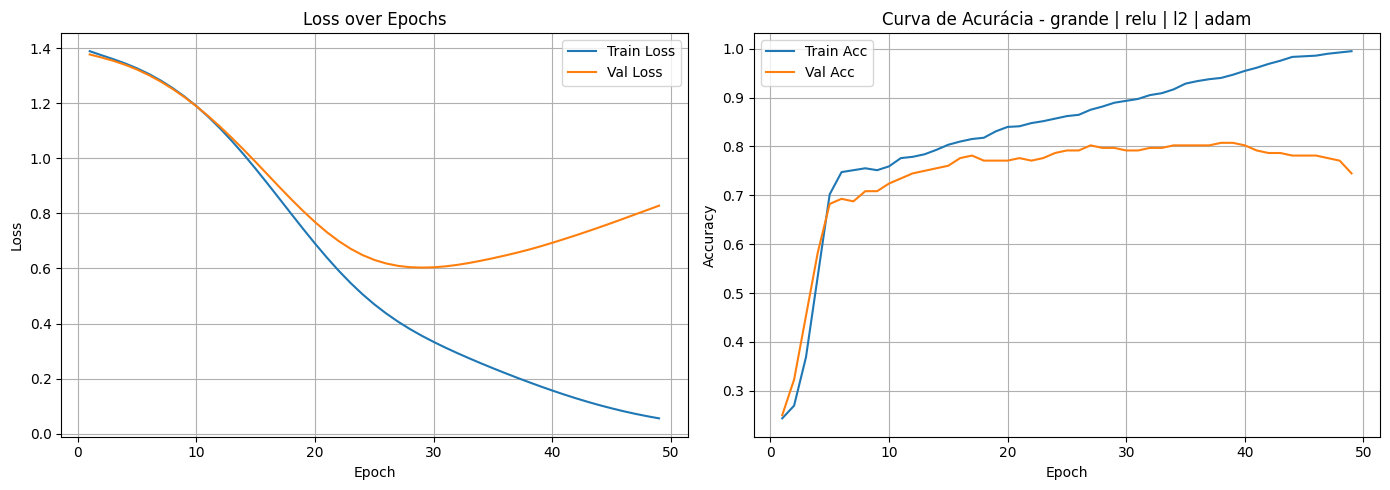

 Conjunto de validação --> Loss: 1.3791, Acurácia: 0.3177
✅ grande | relu | l2 | sgd_l2 => Acc: 0.3292 | Loss: 1.3809


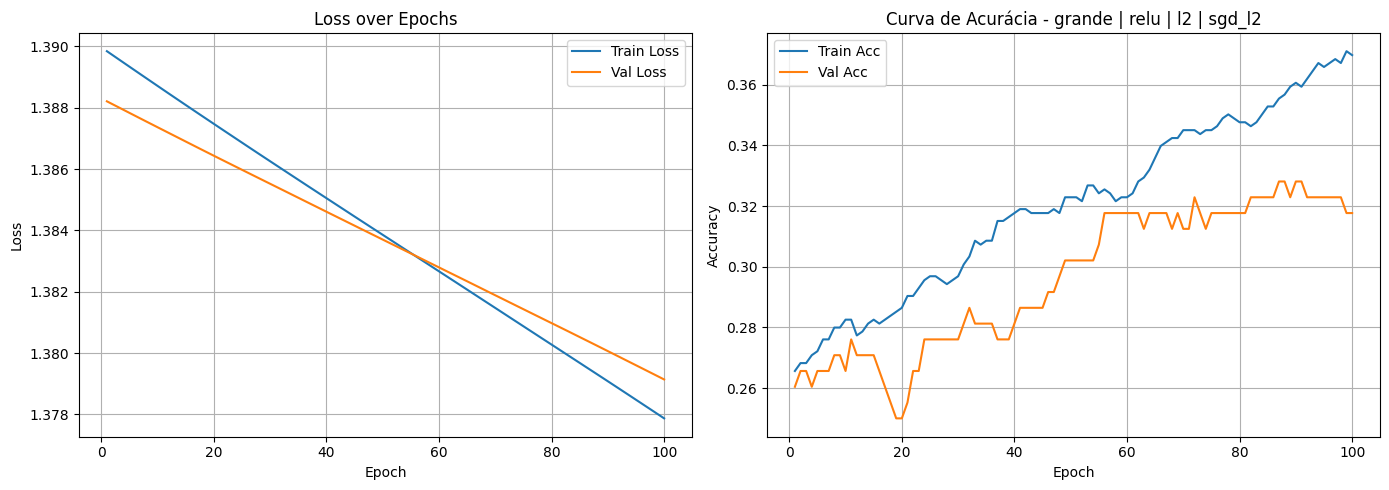

 Conjunto de validação --> Loss: 1.2772, Acurácia: 0.5885
✅ grande | tanh | none | sgd => Acc: 0.7042 | Loss: 1.2536


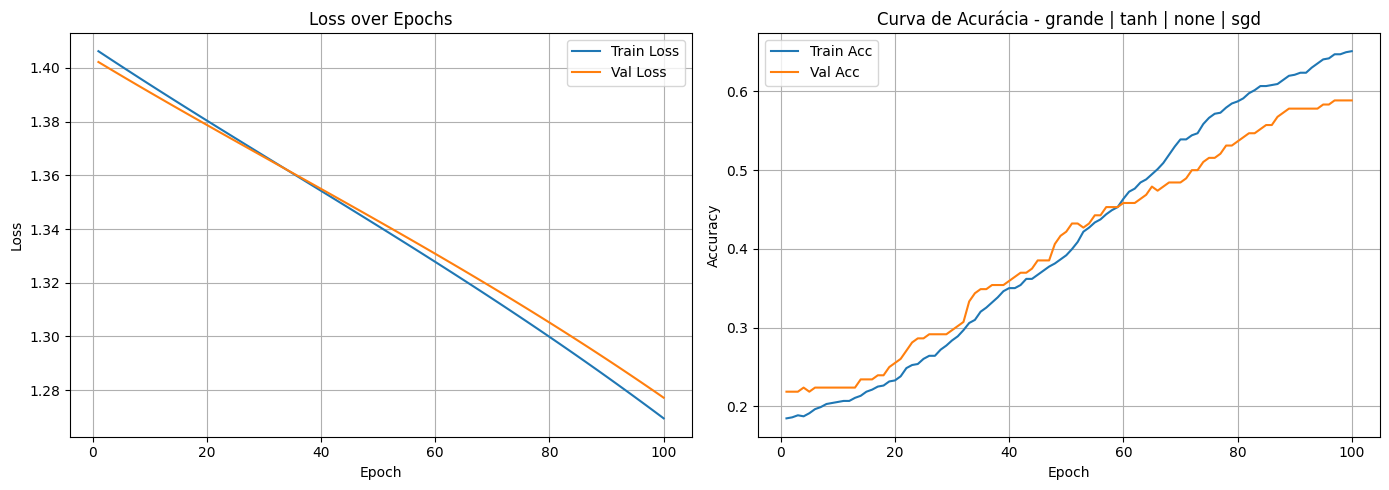

Early stopping triggered.
 Conjunto de validação --> Loss: 0.6000, Acurácia: 0.7812
✅ grande | tanh | none | adam => Acc: 0.7917 | Loss: 0.7095


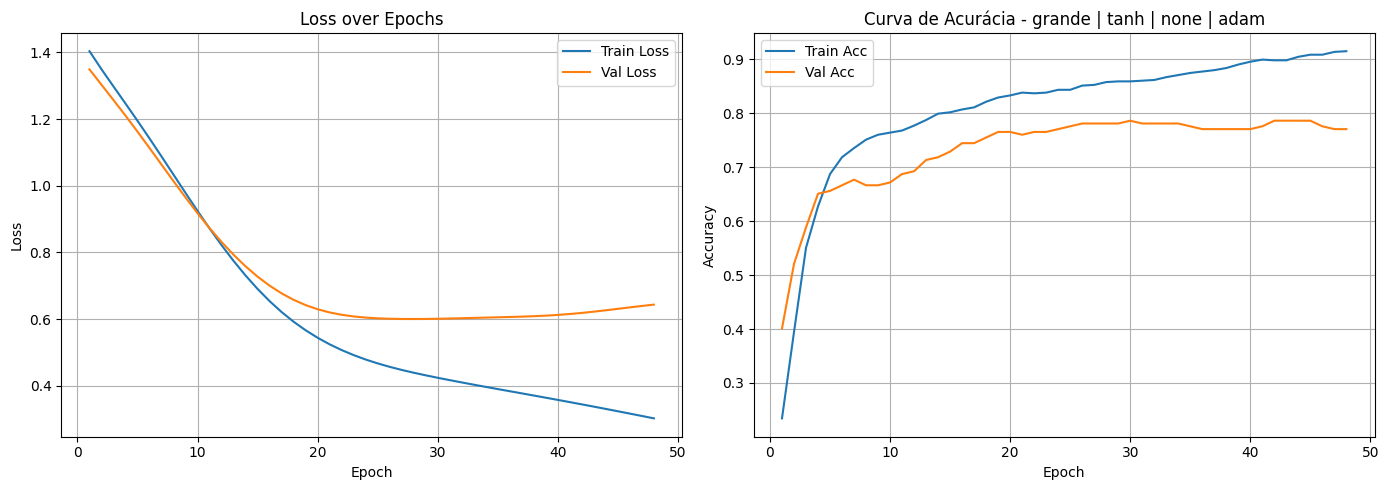

 Conjunto de validação --> Loss: 1.2541, Acurácia: 0.6250
✅ grande | tanh | none | sgd_l2 => Acc: 0.6292 | Loss: 1.2515


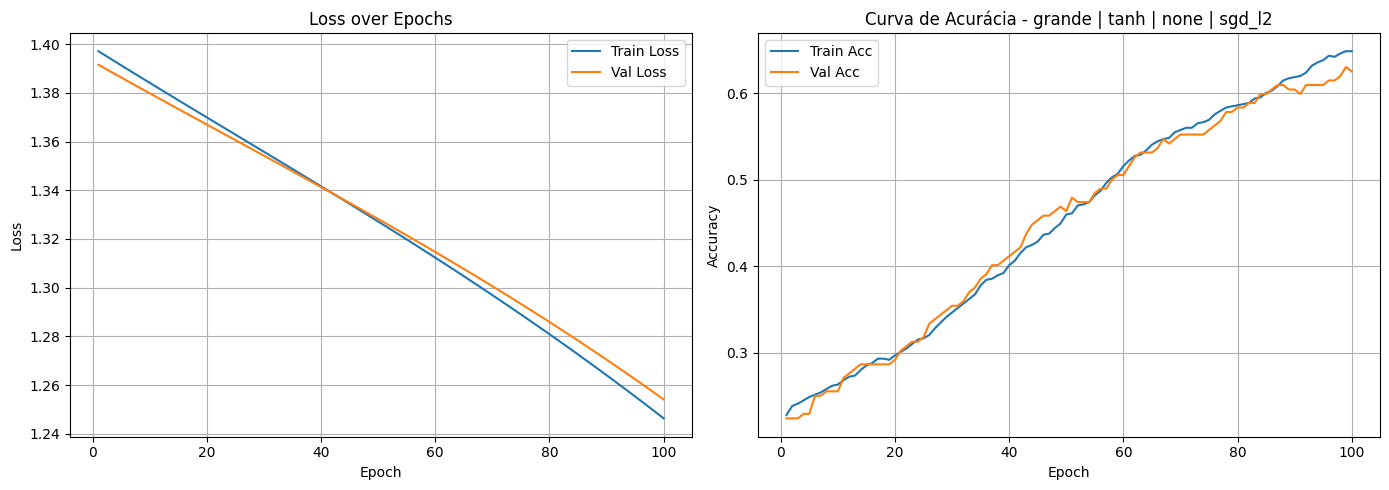

 Conjunto de validação --> Loss: 1.2642, Acurácia: 0.6094
✅ grande | tanh | dropout | sgd => Acc: 0.6042 | Loss: 1.2605


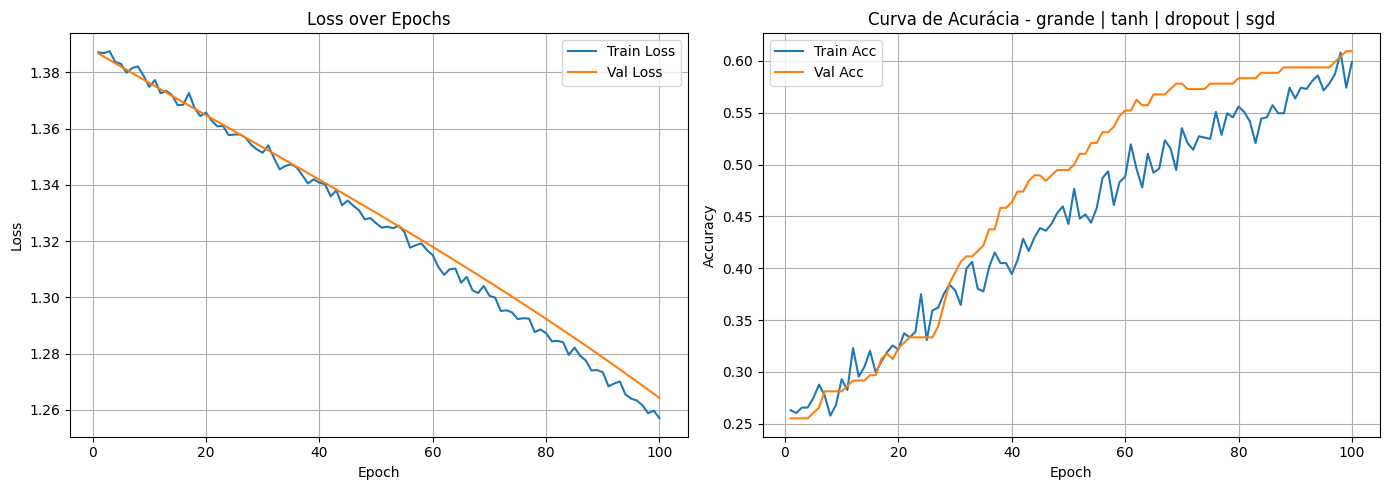

Early stopping triggered.
 Conjunto de validação --> Loss: 0.6076, Acurácia: 0.7917
✅ grande | tanh | dropout | adam => Acc: 0.7917 | Loss: 0.6672


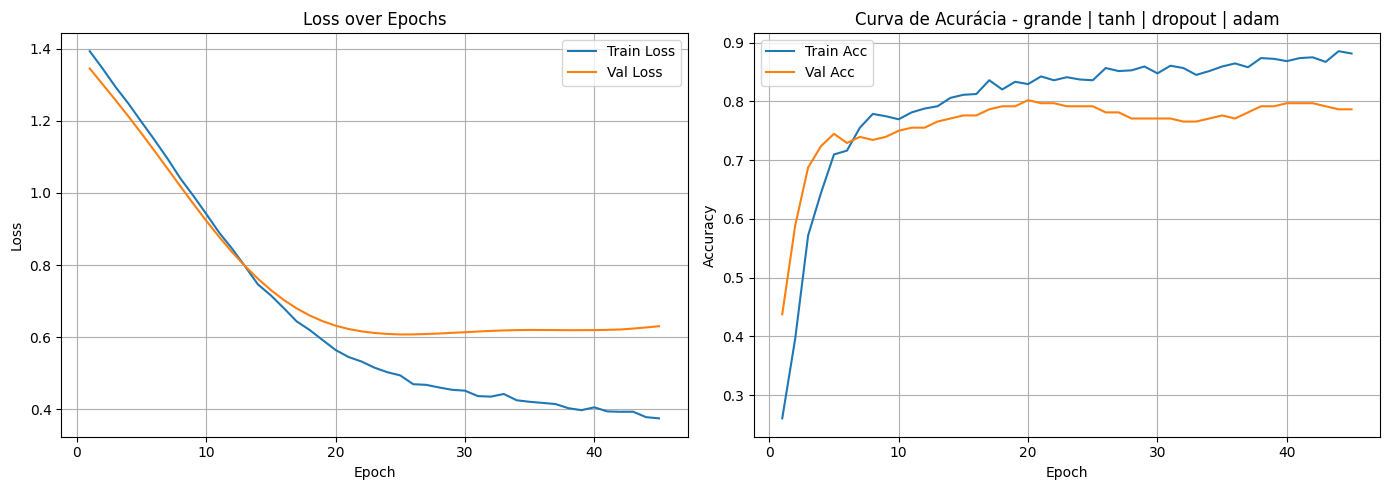

 Conjunto de validação --> Loss: 1.2751, Acurácia: 0.5469
✅ grande | tanh | dropout | sgd_l2 => Acc: 0.5917 | Loss: 1.2528


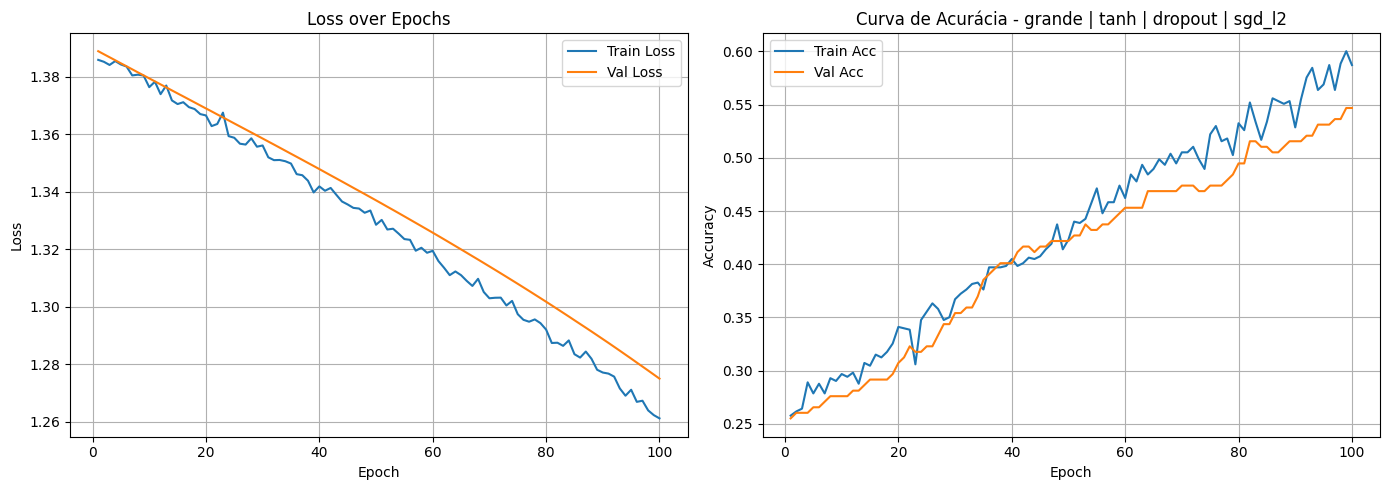

 Conjunto de validação --> Loss: 1.2376, Acurácia: 0.6198
✅ grande | tanh | l2 | sgd => Acc: 0.6375 | Loss: 1.2268


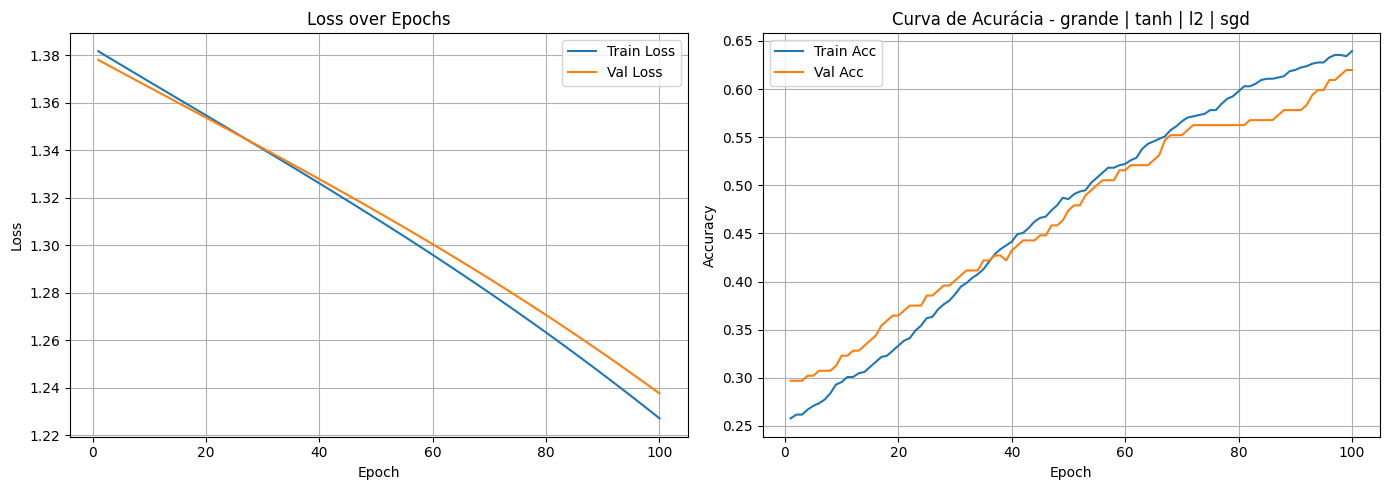

Early stopping triggered.
 Conjunto de validação --> Loss: 0.5899, Acurácia: 0.7865
✅ grande | tanh | l2 | adam => Acc: 0.8000 | Loss: 0.6773


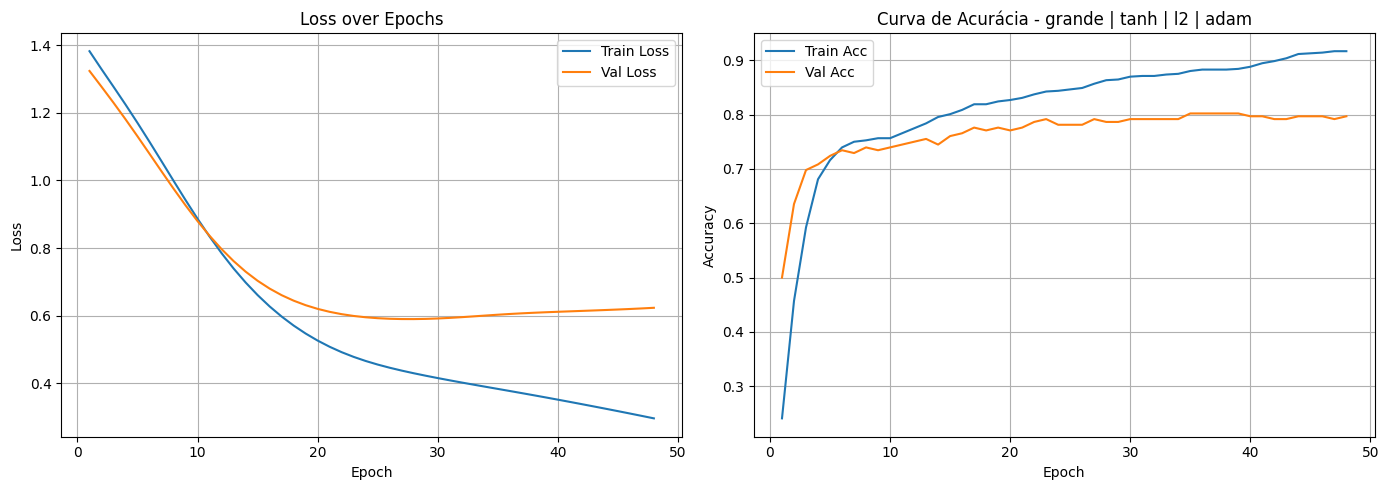

 Conjunto de validação --> Loss: 1.2853, Acurácia: 0.5156
✅ grande | tanh | l2 | sgd_l2 => Acc: 0.5250 | Loss: 1.2816


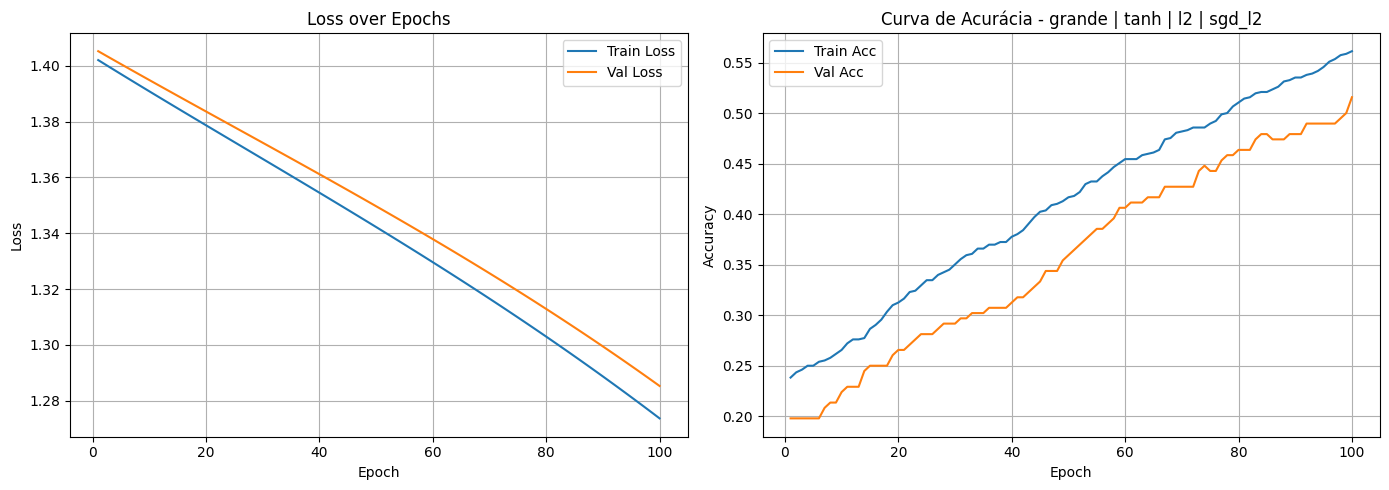

In [73]:
# Loop de experimentos
for nome_arq, arquitetura in arquiteturas.items():
    set_seed(seeds_por_arquitetura[nome_arq])  # fixando seed

    for ativacao, regularizacao, opt in itertools.product(ativacoes, regularizacoes, otimizadores):

        # Dropout
        p_dropout = 0.1 if regularizacao == 'dropout' else 0.0

        # Criação do modelo
        model = MLP(arquitetura, ativacao, p_dropout)

        # Otimizador
        if opt == 'sgd':
            optimizer = torch.optim.SGD(model.parameters(), lr=0.01)
        elif opt == 'adam':
            optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
        elif opt == 'sgd_l2':
            optimizer = torch.optim.SGD(model.parameters(), lr=0.01, weight_decay=0.001)

        # Treinamento
        model_trained, history = train_model_with_validation(
            model, optimizer, criterion_4,
            x_train_tensor_4, y_train_tensor_4,
            x_val_tensor_4, y_val_tensor_4,
            epochs_4, patience_4
        )

        # Avaliação no teste
        test_loss, test_acc = evaluate_model(model_trained, x_test_tensor_4a, y_test_tensor_4a, criterion_4a)

        # Registro
        resultados.append({
            'arquitetura': nome_arq,
            'camadas': str(arquitetura),
            'ativacao': ativacao,
            'regularizacao': regularizacao,
            'otimizador': opt,
            'test_loss': test_loss,
            'test_acc': test_acc
        })

        print(f"✅ {nome_arq} | {ativacao} | {regularizacao} | {opt} => Acc: {test_acc:.4f} | Loss: {test_loss:.4f}")
        plota_treinamento(history, epochs_4, nome_experimento=f"{nome_arq} | {ativacao} | {regularizacao} | {opt}")


# Criação do DataFrame com todos os resultados
df_resultados = pd.DataFrame(resultados)
df_resultados.to_csv("resultados_experimentos.csv", index=False)